In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gensim.downloader as api
import statsmodels.api as sm
import nltk
import importlib
import plotly.graph_objects as go
import warnings
from wordcloud import WordCloud, STOPWORDS
from methods.util import *
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from langdetect import detect
from transformers import pipeline
from statsmodels.datasets import grunfeld
from plotly.subplots import make_subplots
import plotly.io as pio

C:\Users\94042\AppData\Roaming\Python\Python39\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Content:
[1. Data Processing](##Data-Processing)

- [1.1 Convert Data into Json Format](###Convert-Data-into-Json-Format)

[2. K-means Clustering](##Clustering-and-User-Taste-Preference)

- [2.1 Data preparation](###Data-Preparation)

- [2.2 K-means Implementation](###K-means-using-cosine-distance)

- [2.3 Result Visualization](###Visualization)


[3. Beer Style Similarities](##Beer-Style-Similarities)

- [3.1 Match Product Beer Styles with Official Website Style Name](###Match-Product-Beer-Styles-with-Official-Website-Style-Name)

- [3.2 Match Product Beer Styles Manually](###Match-Product-Beer-Styles-Manually)

- [3.3 Convert Style Features into Vectors](###Convert-Style-Features-into-Vectors)

    - [3.3.1 Calculate both the mean and the range for each of the numerical features](####Calculate-both-the-mean-and-the-range-for-each-of-the-numerical-features)

    - [3.3.2 Obtain vector representations for each text features](####Obtain-vector-representations-for-each-text-features)

- [3.4 Calculate Style Similarities](###Calculate-Style-Similarities)


[4. Beer Name, Beer Flavor](##Features-in-beer's-name)

- [4.1 Indentity the language](###Indentity-the-language-for-beer's-name)

- [4.2 Sentiment analysis](###Sentiment-analysis-for-beer's-name)

- [4.3 Regress - Beer Name Reflect Beer Flavor](###Regress---Beer-Name-Reflect-Beer-Flavor)

[5. Beer Recommendation ](##Beer-Recommendation)

- [5.1 Regional Analysis](##Regional-Analysis)

- [5.2 Keyword Analysis](##Keyword-Analysis)

- [5.3 Similarity Recommendation](##Similarity-Recommendation)

- [5.4 Recommendation Function](##Recommendation-Function)

## Data Processing

In [29]:
# Load the data:
beers_m = pd.read_csv('data/m_beers.csv')
ratings_m = pd.read_csv('data/m_ratings.csv')
users_m = pd.read_csv('data/m_users_approx.csv')
breweries_m = pd.read_csv('data/m_breweries.csv')
styles_bab = pd.read_csv('data/beer_styles_bab.csv')
styles_cb = pd.read_csv('data/beer_styles_cb.csv')

# Split matched data, split_matched_data is a function in util.py
beers_rb, beers_ba = split_matched_data(beers_m)
users_rb, users_ba = split_matched_data(users_m)
ratings_rb, ratings_ba = split_matched_data(ratings_m)
breweries_rb, breweries_ba = split_matched_data(breweries_m)

<ipython-input-29-a32fd56fb7d8>:2: DtypeWarning: Columns (0,1,2,3,4,5,8,10,11,12,13,15,16,17,18,19,20,23,25,26,27,29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  beers_m = pd.read_csv('data/m_beers.csv')
<ipython-input-29-a32fd56fb7d8>:3: DtypeWarning: Columns (0,1,2,3,5,7,8,9,10,11,13,17,18,19,20,22,24,25,26,27,29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings_m = pd.read_csv('data/m_ratings.csv')


### Convert Data into Json Format

In [30]:
# Drop nan values
ratings_ba.dropna(inplace=True)
ratings_ba.reset_index(drop=True)

# The type of all the features is 'object'. Convert some of them to float.
convert_features=['abv', 'appearance', 'aroma', 'overall', 'palate', 'rating', 'taste']
ratings_rb[convert_features] = ratings_rb[convert_features].apply(pd.to_numeric, errors = 'coerce')
ratings_ba[convert_features] = ratings_ba[convert_features].apply(pd.to_numeric, errors = 'coerce')

# scaling the features
ratings_rb_with_convert_features = ratings_rb[convert_features]
ratings_ba_with_convert_features = ratings_ba[convert_features]
ratings_rb[convert_features] = (
    ratings_rb_with_convert_features - ratings_rb_with_convert_features.min()
) / (ratings_rb_with_convert_features.max() - ratings_rb_with_convert_features.min())
ratings_ba[convert_features] = (
    ratings_ba_with_convert_features - ratings_ba_with_convert_features.min()
) / (ratings_ba_with_convert_features.max() - ratings_ba_with_convert_features.min())

# Convert Datafrome into json
ratings_rb[convert_features].to_json('viz_data/ratings_rb.json', orient='records')
ratings_ba[convert_features].to_json('viz_data/ratings_ba.json', orient='records')
# Correlation
detailed_features = ['abv', 'appearance', 'aroma', 'palate', 'taste']
ratings_rb[detailed_features].corr().to_json('viz_data/ratings_rb_corr.json', orient='records')
ratings_ba[detailed_features].corr().to_json('viz_data/ratings_ba_corr.json', orient='records')

## Clustering and User Taste Preference

### Data Preparation

In [12]:
# check the nan values in rating 
ratings_rb, ratings_ba = split_matched_data(ratings_m)
numeric_features=['beer_id', 'abv','appearance', 'aroma', 'overall', 'palate', 'rating', 'taste']  
ratings_ba = ratings_ba.dropna(subset=numeric_features).reset_index(drop=True)
ratings_rb = ratings_rb.dropna(subset=numeric_features).reset_index(drop=True)


# The type of all the features is 'object'. Convert some of them to float.
ratings_rb[numeric_features] = ratings_rb[numeric_features].apply(pd.to_numeric, errors = 'coerce')
ratings_ba[numeric_features] = ratings_ba[numeric_features].apply(pd.to_numeric, errors = 'coerce')

# categorize abv
ratings_rb = categorize_abv(ratings_rb)
ratings_ba = categorize_abv(ratings_ba)
# scaling the features (Standardization)
convert_features=['abv_level','appearance', 'aroma', 'overall', 'palate', 'rating', 'taste']

standardize = MinMaxScaler()
ratings_rb[convert_features] = standardize.fit_transform(ratings_rb[convert_features])
ratings_ba[convert_features] = standardize.fit_transform(ratings_ba[convert_features])

ratings_all = pd.concat([ratings_ba, ratings_rb])

### K-means using cosine distance

In [14]:
detailed_features = ['abv_level', 'appearance', 'aroma', 'palate', 'taste']
features_all = ratings_all.set_index('beer_id')[detailed_features]
labeled_ratings = features_all.copy()
labeled_ratings['rating'] = np.array(ratings_all['rating'])

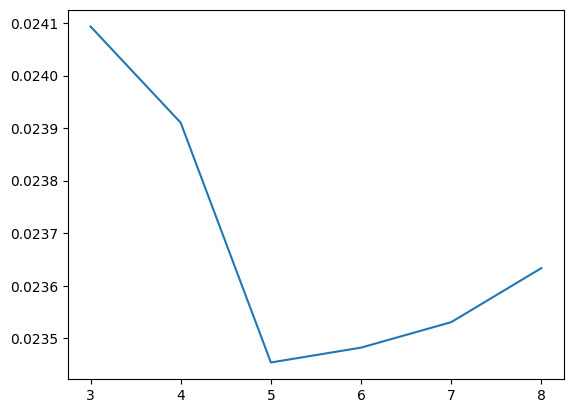

In [15]:
# find an appropriate k for kmeans by ridge regression
find_optimal_k(features_all, ratings_all['rating'])

In [17]:
# do k-means with the selected k
kmeans = CosineKMeans(n_clusters=5, max_iter=500, random_seed=4)
X = features_all.values
kmeans.fit(X)

Some beers present multiple times in the ratings data. We decided to assign their final cluster based on the voting result for all the entries of the corresponding beer. After that we calculated the mean of all rating data for each beer_id in its voted cluster. This process is wrapped in the function `process_clustered_data` in `util.py`

In [18]:
# construct new dataset for plotting:
labels = kmeans.get_labels()
labeled_data = features_all.copy()
labeled_data = labeled_data.reset_index()
labeled_data['rating'] = np.array(ratings_all['rating'])
cleared_labeled_data = process_clustered_data(labeled_data, labels=labels)
# add beer names to the dataframe and save it for future use
id_name = ratings_all[['beer_id', 'beer_name']].drop_duplicates(subset=['beer_id'])
clustered_ratings = pd.merge(cleared_labeled_data, id_name, how='inner', on='beer_id')

### Visualization

In [19]:
save_plot = False
# visualize the clustered beers
fig = visualize_beer_clusters(clustered_ratings)
if save_plot:
    json_graph = pio.to_json(fig)
    with open('vis_clusters.json', 'w') as file:
        file.write(json_graph)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



In [20]:
# Plot the radar chart for each cluster centroids
centroids = kmeans.get_centroids()
# Name each cluster based on their characteristics
names = [
    "Robust & Aromatic Beer",
    "High ABV, Visually Pleasing Beer",
    "Mild ABV, Well-Rounded Beer",
    "Balanced & Pleasant Beer",
    "Aesthetic Low ABV Beer"
]
overalls = cleared_labeled_data.groupby('cluster')['rating'].mean().values
fig = plot_horizontal_radar_charts(centroids, detailed_features, names, overalls)  
if save_plot:
    json_graph = pio.to_json(fig)
    with open('radar_chart.json', 'w') as file:
        file.write(json_graph)

In [21]:
# compute the feature importance for each cluster
cluster_feature_importance = []

for cluster in cleared_labeled_data['cluster'].unique():
    cluster_data = cleared_labeled_data[cleared_labeled_data['cluster'] == cluster]
    X = cluster_data.drop(['rating', 'cluster', 'beer_id'], axis=1)  
    y = cluster_data['rating']

    model = RidgeCV()
    model.fit(X, y)

    # Sort features by the absolute values of their coefficients
    sorted_indices = np.argsort(np.abs(model.coef_))[::-1]
    sorted_features = X.columns[sorted_indices]
    sorted_importances = model.coef_[sorted_indices]

    # Store the sorted features and their importances
    cluster_feature_importance.append({
        'cluster': cluster,
        'features': sorted_features,
        'importances': sorted_importances
    })

In [22]:
fig = create_feature_importance_plot(cluster_feature_importance)
if save_plot:
    json_graph = pio.to_json(fig)
    with open('feature_importance.json', 'w') as file:
        file.write(json_graph)

## Beer Style Similarities

### Match Product Beer Styles with Official Website Style Names

In [31]:
# Get beers style
product_style = pd.concat([beers_ba[['beer_id', 'style']], beers_rb[['beer_id', 'style']]], axis=0)

# Product style set
product_style_set = list(set(product_style['style']))

# Get modified style name and description (official name in a beer style website)
m_styles = pd.read_csv('data/m_styles.csv')
styles_details = pd.merge(m_styles, styles_cb, how='left', left_on='Modified Style Name', right_on='style_name').drop_duplicates()

# List to store the matching results
matched_styles = []

styles_group_1 = styles_details['Original Style Name']
styles_group_2 = styles_bab['style_name']

# Match each style and store the results in the list (use fuzzywuzzy)
for style in styles_group_1:
    matched_style = match_styles(style, styles_group_2)
    matched_styles.append(matched_style)

# Replenish the matching results to Modified Style Name
styles_details['Modified Style Name 2'] = matched_styles
styles_details['Modified Style Name'] = styles_details.apply(replace_style_name, axis=1)
styles_details = styles_details.drop(columns=['Modified Style Name 2'])
styles_details = styles_details.drop(columns=['style_name'])

# List of column names to check
columns_to_check = ['Color_SRM', 'Bitterness_IBU', 'Alcohol_ABV', 'Color', 'Clarity',
                    'Perceived Malt Aroma & Flavor', 'Perceived Hop Aroma & Flavor',
                    'Body']

def fill_missing_values(row):
    if pd.notnull(row['Modified Style Name']):
        if row[columns_to_check].isnull().all():  # Check if all columns are NaN
            # Find the corresponding row in styles_bab
            matching_rows = styles_bab[styles_bab['style_name'] == row['Modified Style Name']]
            if not matching_rows.empty:  # Check if matching rows are found
                fill_values = matching_rows.iloc[0]
                for col in columns_to_check:
                    if pd.isnull(row[col]):
                        row[col] = fill_values[col]
    return row

# Apply this function to every row in styles_details
styles_details = styles_details.apply(fill_missing_values, axis=1)

def replace_varies(row):
    # If the word 'varies' or 'Varies' is present in the 'Color_SRM' column, replace its value with '1-100'
    if 'varies' in str(row['Color_SRM']).lower():
        row['Color_SRM'] = '1-100'
    # If the word 'varies' or 'Varies' is present in the 'Bitterness_IBU' column, replace its value with '1-120'
    if 'varies' in str(row['Bitterness_IBU']).lower():
        row['Bitterness_IBU'] = '1-120'
    # If the word 'varies' or 'Varies' is present in the 'Alcohol_ABV' column, replace its value with '0-15+%'
    if 'varies' in str(row['Alcohol_ABV']).lower():
        row['Alcohol_ABV'] = '0-15%'
    # If other symbol in the 'Alcohol_ABV':
    if '<' in str(row['Alcohol_ABV']):
        row['Alcohol_ABV'] = '0-' + row['Color_SRM'].split(' ')[0][1:]
    if '--' in str(row['Alcohol_ABV']):
        row['Alcohol_ABV'] = '0-100%'
    # If the word with '+' in the 'Color_SRM' column, replace its value with 'the number-100'
    if '+' in str(row['Color_SRM']):
        row['Color_SRM'] = row['Color_SRM'].split('+')[0]+'-100'
    return row

# Apply this function to each row of the styles_details DataFrame
styles_details = styles_details.apply(replace_varies, axis=1)


### Match Product Beer Styles Manually

In [32]:
# Add lost data manually
missing_values = pd.DataFrame([{'style_name': 'American IPA', 'Color_SRM': '6-12', 'Bitterness_IBU': '50-70', 'Alcohol_ABV': '6.3-7.5%', 'Color': 'Gold to Copper, Red/Brown', 'Clarity': 'Clear to Slight Haze', 
                                        'Perceived Malt Aroma & Flavor': 'Biscuit, Bready, Caramel', 'Perceived Hop Aroma & Flavor': 'Hop aroma is high and hop flavor is strong both with floral qualities and citrus-like, piney, resinous or sulfur-like American-variety hop character. Hop bitterness is medium-high to very high', 'Fermentation Characteristics': None, 'Body': 'Soft to Sticky'},
                               {'style_name': 'German-Style Maibock', 'Color_SRM': '4-9', 'Bitterness_IBU': '20-38', 'Alcohol_ABV': '6-8%', 'Color': 'Pale to Light Amber', 'Clarity': 'Clear', 
                                        'Perceived Malt Aroma & Flavor': 'A lightly toasted and/or bready malt aroma is often evident. Roasted or heavy toast/caramel malt aromas should be absent', 'Perceived Hop Aroma & Flavor': 'Hop aroma and flavor are low to medium low, deriving from noble-type hops. Hop bitterness is low', 'Fermentation Characteristics': None, 'Body': 'Soft'},
                               {'style_name': 'Fruit and Field Beer', 'Color_SRM': '5-50', 'Bitterness_IBU': '5-45', 'Alcohol_ABV': '2.5-12%', 'Color': 'Pale to Very Dark', 'Clarity': 'Varies', 
                                        'Perceived Malt Aroma & Flavor': 'Malt sweetness is very low to medium-high', 'Perceived Hop Aroma & Flavor': 'Hop bitterness is very low to medium-high', 'Fermentation Characteristics': None, 'Body': 'Varies'},
                               {'style_name': 'English-Style IPA', 'Color_SRM': '6-14', 'Bitterness_IBU': '35-63', 'Alcohol_ABV': '5-7%', 'Color': 'Gold to Copper', 'Clarity': 'Clear to Slight Haze', 
                                        'Perceived Malt Aroma & Flavor': 'Bready, Biscuit, Toast, Caramel, Toffee', 'Perceived Hop Aroma & Flavor': 'Hop aroma is medium to high, often flowery. Hop flavor and bitterness are medium to high. Earthy and herbal English-variety hop character is perceived, but may be a result of the skillful use of hops of other national origins', 'Fermentation Characteristics': None, 'Body': 'Moderate'},
                               {'style_name': 'German-Style Pilsner', 'Color_SRM': '3-4', 'Bitterness_IBU': '25-50', 'Alcohol_ABV': '4.6-5.3%', 'Color': 'Straw to Pale', 'Clarity': 'Brilliant', 
                                        'Perceived Malt Aroma & Flavor': 'A sweet, malty residual aroma can be perceived. Bready or light biscuity attributes may be present.', 'Perceived Hop Aroma & Flavor': 'Hop flavor is moderate and quite obvious, deriving from late hopping (not dry-hopping) with noble-type hops. Hop bitterness is medium to high', 'Fermentation Characteristics': None, 'Body': 'Soft'},
                               {'style_name': 'American Amber Ale', 'Color_SRM': '11-18', 'Bitterness_IBU': '25-45', 'Alcohol_ABV': '4.4-6.1%', 'Color': 'Copper to Reddish Brown', 'Clarity': 'Clear to Slight Haze', 
                                        'Perceived Malt Aroma & Flavor': 'Caramel', 'Perceived Hop Aroma & Flavor': 'Citrus-like character is acceptable', 'Fermentation Characteristics': None, 'Body': 'Mouth-Coating'},
                               {'style_name': 'Imperial India Pale Ale', 'Color_SRM': '2-9', 'Bitterness_IBU': '65-100', 'Alcohol_ABV': '7.6-10.6%', 'Color': 'Gold to Light Brown', 'Clarity': 'Clear to Hazy', 
                                        'Perceived Malt Aroma & Flavor': 'Malt character is medium to high', 'Perceived Hop Aroma & Flavor': 'Hop flavor and aroma are very high, should be fresh and lively and should not be harsh in quality, deriving from any variety of hops. Hop bitterness is very high but not harsh', 'Fermentation Characteristics': None, 'Body': 'Mouth-Coating'}])

def fill_missing_values(row):
    if pd.notnull(row['Modified Style Name']):
        if row[columns_to_check].isnull().all():  # Check if all columns are NaN
            # Find the corresponding row in styles_bab
            matching_rows = missing_values[missing_values['style_name'] == row['Modified Style Name']]
            if not matching_rows.empty:  # Check if matching rows are found
                fill_values = matching_rows.iloc[0]
                for col in columns_to_check:
                    if pd.isnull(row[col]):
                        row[col] = fill_values[col]
    return row

styles_details = styles_details.apply(fill_missing_values, axis=1).drop(columns=['Fermentation Characteristics'])

# Save the updated DataFrame to a CSV file
styles_details.to_csv('data/beer_style_details.csv')

### Convert Style Features into Vectors

In [34]:
# Load styles details for calculating style similarities
styles_details = pd.read_csv('data/beer_style_details.csv')

# Calculate the number of rows that have at least one NaN value
num_rows_with_nan = styles_details.isna().any(axis=1).sum()

# Calculate the total number of rows in the DataFrame
total_rows = len(styles_details)

# Calculate the proportion of rows with NaN values
proportion_with_nan = num_rows_with_nan / total_rows

# Print the result
print(f"Number of rows with NaN values: {num_rows_with_nan:d}")
print(f"total number of rows in the DataFrame: {total_rows:d}")
print(f"Proportion of rows with NaN values: {proportion_with_nan:.2f}")

styles_details = styles_details.dropna().drop(columns=['Unnamed: 0']).copy(deep=True)
display(styles_details)

Number of rows with NaN values: 23
total number of rows in the DataFrame: 171
Proportion of rows with NaN values: 0.13


,Original Style Name,Modified Style Name,Color_SRM,Bitterness_IBU,Alcohol_ABV,Color,Clarity,Perceived Malt Aroma & Flavor,Perceived Hop Aroma & Flavor,Body
1,Scottish Ale,Scottish-Style Ale,6-19,9-25,2.8-5.3%,Gold to Dark Chestnut or Brown,Clear,"Caramel, Toffee",Hop aroma and flavor are not perceived. Hop bi...,Soft
2,Pilsener,Bohemian-Style Pilsener,3-7,30-45,4.1-5.1%,Straw to Light Amber,Clear to Brilliant,"Toasted, biscuit-like, and/or bready malt flav...","Hop aroma and flavor are low to medium-low, de...",Soft
3,Brown Ale,American Brown Ale,15-26,25-45,4.2-6.3%,Deep Copper to Very Dark Brown,Clear,"Caramel, Chocolate, Toast",Hop aroma and flavor are low to medium. Hop bi...,Varies
4,Scotch Ale / Wee Heavy,Scotch Ale/Wee Heavy,15-30,25-35,6.2-8%,Light Reddish Brown to Very Dark,Clear,"Dominated by a smooth, balanced sweet maltines...",Hop aroma and flavor are not perceived. Hop bi...,Mouth-Coating
5,Smoked Beer,Smoke Beer,1-100,1-120,0-15%,Varies,Varies,Varies,Varies,Varies
...,...,...,...,...,...,...,...,...,...,...
162,Scotch Ale,Scotch Ale/Wee Heavy,15-30,25-35,6.2-8%,Light Reddish Brown to Very Dark,Clear,"Dominated by a smooth, balanced sweet maltines...",Hop aroma and flavor are not perceived. Hop bi...,Mouth-Coating
164,Munich Dunkel Lager,South German-Style Dunkel Weizen,20-50,10-15,4.80%-5.40%,Copper-brown to very dark,"If served with yeast, appearance may be very c...",Distinct sweet maltiness and a chocolate-like ...,Not present,Medium to full
165,English Pale Ale,English-Style Pale Ale (ESB),5-16,20-40,4.5-5.5%,Gold to Copper,Clear to Brilliant,Residual malt and defining sweetness is medium...,Hop flavor is medium to medium-high. Hop bitte...,Moderate
166,Bock,German-Style Bock,20-30,20-30,6.3-7.5%,Dark Brown to Very Dark,Clear,High malt character with aromas of toasted or ...,Hop flavor is low. Hop bitterness is perceived...,Soft


#### Calculate both the mean and the range for each of the numerical features

In [35]:
# Function to convert percentage range strings to their mean float value and range
def percent_range_to_mean_and_range(x):
    # Split the string by the hyphen to get the range
    range_parts = x.split('-')
    # Remove the percentage sign and convert to float
    range_values = [float(part.strip('%')) for part in range_parts]
    # Calculate the mean of the range and the range width
    range_mean = np.mean(range_values) / 100  # divide by 100 to convert to decimal
    range_width = (max(range_values) - min(range_values)) / 100 if len(range_values) > 1 else 0
    return range_mean, range_width

# Function to get the mean and range width of a numerical range
def mean_and_range_of_range(x):
    if '-' in x:
        nums = [float(n) for n in x.split('-')]
        return np.mean(nums), max(nums) - min(nums)
    else:
        return float(x), 0

# Apply the functions to convert ranges to their mean values and range widths
styles_details[['Color_SRM_mean', 'Color_SRM_range']] = styles_details['Color_SRM'].apply(
    lambda x: pd.Series(mean_and_range_of_range(x))
)
styles_details[['Bitterness_IBU_mean', 'Bitterness_IBU_range']] = styles_details['Bitterness_IBU'].apply(
    lambda x: pd.Series(mean_and_range_of_range(x))
)
styles_details[['Alcohol_ABV_mean', 'Alcohol_ABV_range']] = styles_details['Alcohol_ABV'].apply(
    lambda x: pd.Series(percent_range_to_mean_and_range(x))
)

# Normalize the numerical features including the ranges
numerical_features = ['Color_SRM_mean', 'Bitterness_IBU_mean', 'Alcohol_ABV_mean',
                      'Color_SRM_range', 'Bitterness_IBU_range', 'Alcohol_ABV_range']
scaler = MinMaxScaler()
styles_details[numerical_features] = scaler.fit_transform(styles_details[numerical_features])


#### Obtain vector representations for each text features

In [36]:
# Load the model
glove_model = api.load('glove-wiki-gigaword-50')

# Define your function for converting text to a vector
def document_vector(doc):
    words = [word for word in doc.lower().split() if word in glove_model.key_to_index]
    if len(words) == 0:
        return np.zeros(50)
    return np.mean(glove_model[words], axis=0)

# Concatenate all text features into a single string for each row
styles_details['combined_text'] = styles_details.apply(lambda row: ' '.join([str(row[feature]) for feature in ['Color', 'Clarity', 'Perceived Malt Aroma & Flavor', 'Perceived Hop Aroma & Flavor', 'Body']]), axis=1)

# Apply the document_vector function to the combined text
styles_details['text_vec'] = styles_details['combined_text'].apply(document_vector)

### Calculate Style Similarities

In [37]:
# Concatenate all features into a single vector for each row
styles_details['combined_vector'] = styles_details.apply(
    lambda row: np.concatenate([
        row[numerical_features].values, 
        row['text_vec']
    ]),
    axis=1
)

# Convert the combined vectors into a matrix
combined_vectors_matrix = np.vstack(styles_details['combined_vector'].values)

# Calculate cosine similarity matrix
similarity_matrix = cosine_similarity(combined_vectors_matrix)

identifiers = styles_details['Original Style Name'].values  # Replace 'Style_Name' with the appropriate column name or index

# Create a DataFrame for the similarity matrix
similarity_df = pd.DataFrame(similarity_matrix, index=identifiers, columns=identifiers)

# Save to a CSV file
similarity_df.to_csv('data/similarity_matrix.csv')

## Beer Name, Beer Flavor
[back to content](#Content)

In [27]:
# merge ratings_rb and beers_rb to get beer_without_brewery_name
ratings_rb_name = ratings_rb.merge(beers_rb[['beer_name','beer_wout_brewery_name']], on ="beer_name" ,how = "left")
ratings_rb_name['beer_wout_brewery_name'].fillna(ratings_rb_name['beer_name'], inplace=True)

ratings_ba_name = ratings_ba.merge(beers_ba[['beer_name','beer_wout_brewery_name']], on ="beer_name" ,how = "left")
ratings_ba_name['beer_wout_brewery_name'].fillna(ratings_ba_name['beer_name'], inplace=True)

### Indentity the language for beer's name

The beers' names vary not only in style but also in the language they are presented in, from English to Finnish, Hungarian, and more.

Here we use the langdetect package to indentity the language.

In [28]:
ratings_rb_withid_lang = ratings_rb_name.copy()
ratings_ba_withid_lang = ratings_ba_name.copy()

In [29]:
# Extract a list of beer names from the 'beer_wout_brewery_name' column
beer_names = ratings_rb_withid_lang['beer_wout_brewery_name']

# Create a new column 'language' 
# by applying the 'detect_language' function to each 'beer_wout_brewery_name'
ratings_rb_withid_lang['language'] = ratings_rb_withid_lang['beer_wout_brewery_name'].apply(detect_language)

In [30]:
# for BA data
beer_names = ratings_ba_withid_lang['beer_wout_brewery_name']
ratings_ba_withid_lang['language'] = ratings_ba_withid_lang['beer_wout_brewery_name'].apply(detect_language)

#### Calculate the distribution of Language

In [31]:
# Drop rows with missing values in the 'language', 'rating', and 'beer_wout_brewery_name' columns
ratings_rb_withid_lang = ratings_rb_withid_lang.dropna(subset=['language', 'rating', 'beer_wout_brewery_name'])
ratings_ba_withid_lang = ratings_ba_withid_lang.dropna(subset=['language','rating', 'beer_wout_brewery_name'])

In [32]:
ratings_ba_withid_lang.groupby('language')['language'].count().sort_values()

language
sk            22
cs            28
unknown       38
vi            48
hr            69
sq            92
hu           109
lt           116
lv           128
pl           196
so           279
tr           299
cy           332
fi           400
sw           435
sv           498
af           549
ca           566
no           582
et           688
sl           737
pt           743
tl           759
es           773
ro          1246
it          1264
nl          1298
da          1511
id          2583
fr          4579
de          8951
en         11472
Name: language, dtype: int64

In [21]:
# generate the dataframe of language_percentage for 10 languages
top10_lan = ['en', 'de', 'fr', 'nl', 'ro', 'id', 'it', 'da', 'no','es']

#### Plot the distribution of Language

In [35]:
language_percentage_rb = language_dis(ratings_rb_withid_lang)
language_percentage_ba = language_dis(ratings_ba_withid_lang)

[3.118739755964305, 15.912402112547804, 35.257694409032965, 2.0852303769805136, 7.6761974139501, 3.4511018029502822, 3.296303041340375, 3.992897468584957, 2.2309233290839554, 19.39537424877072, 3.5831360407940265]
[3.650640251268422, 21.62599661754047, 27.716839816380766, 1.8676008697753081, 11.063058709833292, 6.2406378352258995, 3.053877748248369, 3.1360231940082146, 1.4061367480067648, 17.2287992268664, 3.010388982846098]


### Sentiment analysis for beer's name

Beer names come in a wide range of styles, from straightforward descriptions like "Co-op Wheat Beer" to creatively evocative ones like "Just Married" or "Pheasantry Dancing Dragonfly".

We score it with variable $𝑁𝑎𝑚𝑒𝑆𝑒𝑛𝑡𝑖𝑚𝑒𝑛𝑡$ expressing whether the bear's name is positive or negative, and to what extent it is, using an NLP model for sentiment analysis.

Here we use pipeline (transformers package) and nlptown/bert-base-multilingual-uncased-sentiment model, since there are too many languages.

Based on this, our analysis focuses on English, French, Italian, German, Spanish and Dutch.

In [53]:
# Load pre-trained sentiment analysis model for multiple languages
sentiment_analyzer_multilingual = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')

# for RB data
results = sentiment_analyzer_multilingual(list(ratings_rb_withid_lang['beer_wout_brewery_name']))
print(results)

ratings_rb_withid_lang = pd.concat([ratings_rb_withid_lang, pd.DataFrame(results)], axis=1)

# for BA data
results_ba = sentiment_analyzer_multilingual(list(ratings_ba_withid_lang['beer_wout_brewery_name']))

ratings_ba_withid_lang = pd.concat([ratings_ba_withid_lang, pd.DataFrame(results_ba)], axis=1)

"This is a bert-base-multilingual-uncased model finetuned for sentiment analysis on product reviews in six languages: English, Dutch, German, French, Spanish, and Italian. It predicts the sentiment of the review as a number of stars (between 1 and 5)."

In [58]:
# Define a mapping of sentiment labels to numerical values
label_mapping = {
    '1 star': 1,
    '2 stars': 2,
    '3 stars': 3,
    '4 stars': 4,
    '5 stars': 5
}
ratings_rb_withid_lang['NameSentiment'] = ratings_rb_withid_lang['label'].map(label_mapping)
ratings_ba_withid_lang['NameSentiment'] = ratings_ba_withid_lang['label'].map(label_mapping)

In [6]:
ratings_rb_withid_lang.head()

,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,...,style,taste,text,user_id,user_name,beer_wout_brewery_name,language,label,score,NameSentiment
0,11.3,4.0,10.0,2360.0,Rochefort Trappistes 10,406.0,Brasserie Rochefort,1.387710e+09,19.0,4.0,...,Abt/Quadrupel,9.0,a) Geruch malzig-schwer-sÃ¼Ã. Riecht schon ...,83106.0,Erzengel,Trappistes 10,fr,5 stars,0.314458,5
1,5.0,2.0,3.0,17109.0,Myanmar Lager Beer,2921.0,Myanmar Brewery and Distillery,1.322564e+09,6.0,2.0,...,Pale Lager,4.0,"Can. Weak and watery, not the best beer of the...",91324.0,visionthing,Beer Lager,de,5 stars,0.340433,5
2,5.0,4.0,8.0,35298.0,Cantillon Tyrnilambic Baie dArgousier,1069.0,Cantillon,1.353582e+09,17.0,4.0,...,Lambic Style - Fruit,8.0,"Bottle @ One Pint Pub, Helsinki. Originally ra...",98624.0,tiong,dArgousier Baie Tyrnilambic,fr,3 stars,0.283780,3
3,5.0,4.0,8.0,113596.0,Cantillon Pikkulinnun Viskilambic,1069.0,Cantillon,1.416222e+09,16.0,4.0,...,Lambic Style - Unblended,9.0,"Draught @Â Pikkulintu, Helsinki, Finland. A pr...",98624.0,tiong,Viskilambic Pikkulinnun,et,4 stars,0.253179,4
4,6.0,4.0,8.0,173481.0,3 Fonteinen Oude Geuze (Armand & Tommy),2058.0,Brouwerij 3 Fonteinen,1.345284e+09,16.0,4.0,...,Lambic Style - Gueuze,8.0,750ml bottleBottling date: 2011/02/17 - Pours ...,98624.0,tiong,Oude Geuze Armand Tommy,de,5 stars,0.371943,5


#### Plot for the sentiment of beer's name

In [10]:
# Define a list of languages for focus in the analysis
lan6 = ['en', 'de', 'fr', 'nl', 'es', 'it']

# Filter the 'ratings_rb_withid_lang' DataFrame to include only records for the specified languages
ratings_rb_withid_6lan = ratings_rb_withid_lang[ratings_rb_withid_lang['language'].isin(lan6)]

# Filter the 'ratings_ba_withid_lang' DataFrame to include only records for the specified languages
ratings_ba_withid_6lan = ratings_ba_withid_lang[ratings_ba_withid_lang['language'].isin(lan6)]

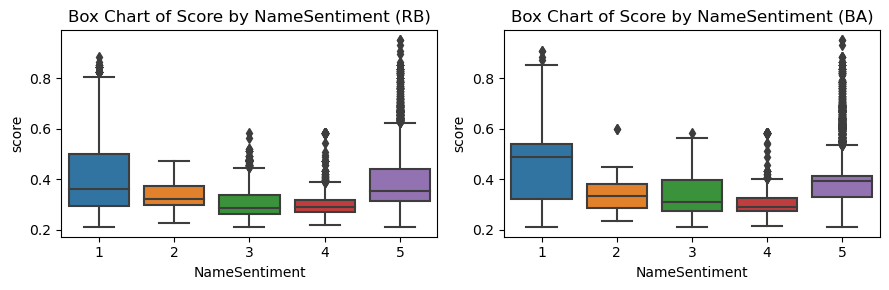

In [11]:
# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(9, 3))

# Plot the box chart for 'ratings_rb_withid_lang'
sns.boxplot(x = 'NameSentiment', y = 'score', data = ratings_rb_withid_6lan, ax=axes[0])
axes[0].set_title('Box Chart of Score by NameSentiment (RB)')

# Plot the box chart for 'ratings_ba_withid_lang'
sns.boxplot(x = 'NameSentiment', y = 'score', data = ratings_ba_withid_6lan, ax=axes[1])
axes[1].set_title('Box Chart of Score by NameSentiment (BA)')

# Adjust layout
plt.tight_layout()

plt.show()


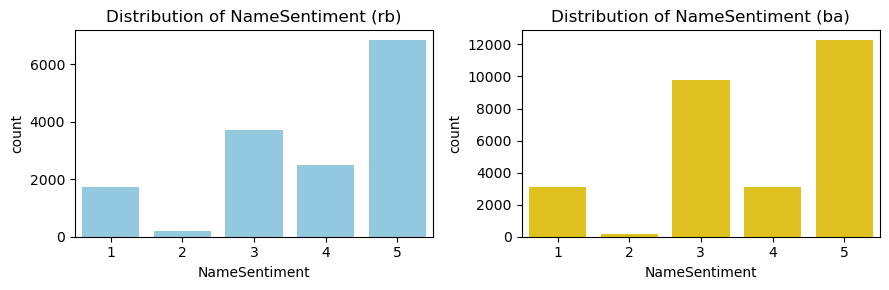

In [12]:
# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(9, 3))

# Plot the distribution for 'ratings_rb_withid_lang'
sns.countplot(x='NameSentiment', data=ratings_rb_withid_6lan, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of NameSentiment (rb)')

# Plot the distribution for 'ratings_ba_withid_lang'
sns.countplot(x='NameSentiment', data=ratings_ba_withid_6lan, ax=axes[1], color='gold')
axes[1].set_title('Distribution of NameSentiment (ba)')

# Adjust layout
plt.tight_layout()

plt.show()

### Regress - Beer Name Reflect Beer Flavor

We plan to run the linear models:
$$Rating_{i,j} = \beta_0 + \beta_{1,k} NameLanguages_{i,k} + \beta_2  X_i + \beta_3  Y_j +\epsilon_{i,j} \tag{1}$$ 

$$Rating_{i,j} = \beta_0 + \beta_1 NameSentiment_i + \beta_{2,k} NameLanguages_{i,k} + \beta_3  X_i + \beta_4  Y_j +\epsilon_{i,j} \tag{2}$$

$$Rating_{i,j} = \beta_0 + \beta_{1,k} NameSentiments_{i,j} \times  NameLanguages_{i,k} + \beta_{2,k} NameLanguages_{i,k} + \beta_3 NameSentiments_{i,j} + \beta_4  X_i + \beta_5  Y_j +\epsilon_{i,j} \tag{3}$$

$$Characteristics_{i,j} = \beta_0 + \beta_1 NameSentiment_i + \beta_{2,k} NameLanguages_{i,k} + \beta_3  X_i + \beta_4  Y_j +\epsilon_{i,j} \tag{4}$$

where $i$ indicates the beer, $j$ indicates the user, and $k$ indicates the language; $Rating_{i,j}$ could be the rating score or sentiment of rating text;

$NameSentiments_{i,j}$ is a variable used to measure language emotion, with a value from 1 to 5;

$NameLanguages_{i,k}$ is a dummy variable of the language of beer's name. We focus on the 10 most frequently occurring languages.
For example, if the language of beer i is language k, $NameLanguages_{i,k} = 1$.

$Characteristics_{i,j}$ could be alcohol by volume (abv), appearance, aroma, palate, and taste;

$X_i$ are control variables of beers, like $style$; 

$Y_j$ are control variables of users, like $location$, $country$; 

$\beta_0$ is an overall constant. 

We already utilized NLP model to get $NameSentiments_i$  $NameLanguages_i$.

#### Processing before return

In [13]:
# STEP 1. Add user and location as control variables
ratings_rb_withid_reg = ratings_rb_withid_lang.merge(users_rb[['user_name','location']], on ="user_name", how="left")
ratings_ba_withid_reg = ratings_ba_withid_lang.merge(users_ba[['user_name','location']], on ="user_name", how="left")
ratings_rb_withid_reg = ratings_rb_withid_reg.dropna(subset=['language', 'rating', 'beer_wout_brewery_name','location','style'])
ratings_ba_withid_reg = ratings_ba_withid_reg.dropna(subset=['language','rating', 'beer_wout_brewery_name','location','style'])

In [14]:
# STEP 2. Since there are too many locations, we classify them, and map to the areas
ratings_ba_withid_reg['location'].unique()

array(['Germany', 'Estonia', 'Finland', 'England', 'Netherlands',
       'Belarus', 'Switzerland', 'Scotland', 'Norway',
       'United States, Maryland', 'Sweden', 'Mexico', 'Czech Republic',
       'Canada', 'Slovenia', 'United States, Georgia',
       'United States, Connecticut', 'United States, Virginia',
       'United States, Ohio', 'United States, California', 'Belgium',
       'United States, Florida', 'United States, Pennsylvania',
       'United States, Colorado', 'United States, Washington',
       'United States, Illinois', 'United States, New Hampshire',
       'United States, Louisiana', 'United States, New York',
       'United States, South Carolina', 'United States, Oregon',
       'Thailand', 'Spain', 'Australia', 'United States, Massachusetts',
       'United States, Wisconsin', 'Malaysia', 'United States, Texas',
       'United States, New Jersey', 'United States, Michigan',
       'United States, Arizona', 'United States, Indiana',
       'United States, Idaho', '

In [16]:
### this part is copied from Yihan's part
# Extract the country from each location
ratings_rb_withid_reg['country'] = ratings_rb_withid_reg['location'].apply(extract_country)

# Map each country to its world area
ratings_rb_withid_reg['world_area'] = ratings_rb_withid_reg['country'].map(world_area_mapping)

# Extract the country from each location
ratings_ba_withid_reg['country'] = ratings_ba_withid_reg['location'].apply(extract_country)

# Map each country to its world area
ratings_ba_withid_reg['world_area'] = ratings_ba_withid_reg['country'].map(world_area_mapping)

In [17]:
ratings_rb_withid_reg = ratings_rb_withid_reg.dropna(subset=['NameSentiment', 'language', 'style', 'rating','location'])
ratings_ba_withid_reg = ratings_ba_withid_reg.dropna(subset=['NameSentiment', 'language', 'style', 'rating','location'])

In [18]:
# STEP 3: Set dummies

#### Model (1)
$$Rating_{i,j} = \beta_0 + \beta_{1,k} NameLanguages_{i,k} + \beta_2  X_i + \beta_3  Y_j +\epsilon_{i,j} \tag{1}$$ 

where where $i$ indicates the beer, $j$ indicates the user, and $k$ indicates the language; 

$Y_j$ is control variable of users: $country_i$.

$NameLanguages_{i,k}$ is a dummy variable of the language of beer's name. We focus on the 10 most frequently occurring languages.
For example, if the language of beer i is language k, $NameLanguages_{i,k} = 1$.

In [22]:
# Model (1) for RB (Ratings by Beer)

# Apply dummy encoding for categorical variables (styles, languages, locations, countries)
ratings_rb_withid_reg, style_dummies, language_dummies, location_dummies, country_dummies = set_dummy(ratings_rb_withid_reg)

# Concatenate independent variables (top 10 languages, style dummies, country dummies)
X = pd.concat([ratings_rb_withid_reg[top10_lan], style_dummies, country_dummies], axis=1)

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Define the dependent variable (y)
y = ratings_rb_withid_reg['rating']

# Fit the Ordinary Least Squares (OLS) model with Heteroskedasticity-Robust standard errors (HC1)
model1_rb = sm.OLS(y, X).fit(cov_type='HC1')

# Print the summary of the regression model
print(model1_rb.summary())


                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     141.7
Date:                Thu, 21 Dec 2023   Prob (F-statistic):               0.00
Time:                        13:24:29   Log-Likelihood:                -16761.
No. Observations:               21964   AIC:                         3.378e+04
Df Residuals:                   21837   BIC:                         3.479e+04
Df Model:                         126                                         
Covariance Type:                  HC1                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

C:\Users\CZX\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 126, but rank is 120
  warnings.warn('covariance of constraints does not have full '


In [23]:
# Model (1) for BA (Ratings by Brewery)
# Define independent variables (X) and the dependent variable (y)

# Apply dummy encoding for categorical variables (styles, languages, locations, countries)
ratings_ba_withid_reg, style_dummies, language_dummies, location_dummies, country_dummies = set_dummy(ratings_ba_withid_reg)

# Concatenate independent variables (top 10 languages, style dummies, country dummies)
X = pd.concat([ratings_ba_withid_reg[top10_lan], style_dummies, country_dummies], axis=1)

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Define the dependent variable (y)
y = ratings_ba_withid_reg['rating']

# Fit the Ordinary Least Squares (OLS) model with Heteroskedasticity-Robust standard errors (HC1)
model1_ba = sm.OLS(y, X).fit(cov_type='HC1')

# Print the summary of the regression model
print(model1_ba.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     3467.
Date:                Thu, 21 Dec 2023   Prob (F-statistic):               0.00
Time:                        13:24:34   Log-Likelihood:                -28339.
No. Observations:               41403   AIC:                         5.698e+04
Df Residuals:                   41251   BIC:                         5.829e+04
Df Model:                         151                                         
Covariance Type:                  HC1                                         
                                                coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

C:\Users\CZX\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 151, but rank is 145
  warnings.warn('covariance of constraints does not have full '


We save the important regression coefficients in df and draw the graph.

In [25]:
CI_model1_rb = CI_reg1(model1_rb,top10_lan)

['English', 'German', 'French', 'Dutch', 'Romanian', 'Indonesian', 'Italian', 'Danish', 'Norwegian', 'Spanish']
[0.008185038532063517, 0.03804686605318555, -0.013428427153255214, -0.0025446473708672923, -0.016674237559662963, 0.011504832148072864, -0.040179010848084326, 0.01393994726359641, -0.06087115791001041, 0.04183980006342983]
[0.02023133292694169, 0.02554899126793139, 0.032472098586244336, 0.03959186998865557, 0.03861301058246559, 0.041495095182665934, 0.04451508595264238, 0.04299742803352185, 0.04755074305549076, 0.053476716628750226]


In [26]:
CI_model1_ba = CI_reg1(model1_ba,top10_lan)

['English', 'German', 'French', 'Dutch', 'Romanian', 'Indonesian', 'Italian', 'Danish', 'Norwegian', 'Spanish']
[-0.034222357237830126, -0.01255126976858291, -0.06909250616074117, 0.053412065742694304, -0.13660996225407496, -0.05390083332560511, -0.010126155880029693, 0.017854524581935816, -0.11117633726063286, -0.024698439259874683]
[0.016284318585415278, 0.020333548170736265, 0.023336221636894278, 0.0308424736751262, 0.034979304673233375, 0.0257641151563293, 0.03292010959690194, 0.028006884252783075, 0.04363852179614124, 0.043840820194945465]


We found that the language of a beer’s name had a significant impact on its rating. Among them, compared with other languages, the distribution of German and Dutch beer names can increase the beer score by 0.04, 0.05, at a 5% confidence level.

Interestingly, the two languages are considered highly similar. We speculate that this may be related to German beer culture and reputation.

#### Model (2)
$$Rating_{i,j} = \beta_0 + \beta_1 NameSentiment_i + \beta_{2,k} NameLanguages_{i,k} + \beta_3  X_i + \beta_4  Y_j +\epsilon_{i,j} \tag{2}$$

where where $i$ indicates the beer, $j$ indicates the user, and $k$ indicates the language; 

$Y_j$ is control variable of users: $location_i$.

$NameSentiments_{i,j}$ is a variable used to measure language emotion, with a value from 1 to 5.

$NameLanguages_{i,k}$ is a dummy variable of the language of beer's name.

Our sample is beers with names in English, French, Italian, German, Spanish and Dutch. In the process of regression, we divided the samples as sub -samples according to the region and focus on $NameSentiment_i$.

In [31]:
lan6

['en', 'de', 'fr', 'nl', 'es', 'it']

In [32]:
# model (2) - rb
# Filter the dataset to include only records with languages in 'lan6' -- English, French, Italian, German, Spanish and Dutch
ratings_rb_withid_reg_6 = ratings_rb_withid_reg[ratings_rb_withid_reg['language'].isin(lan6)]

# Define independent variables (X) and the dependent variable (y) using dummy variables
ratings_rb_withid_reg_6, style_dummies, language_dummies, location_dummies, country_dummies = set_dummy(ratings_rb_withid_reg_6)
X = pd.concat([ratings_rb_withid_reg_6['NameSentiment'], ratings_rb_withid_reg_6[lan6], style_dummies, country_dummies], axis=1)

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Define the dependent variable (y)
y = ratings_rb_withid_reg_6['rating']

# Fit Ordinary Least Squares (OLS) model
model2_rb = sm.OLS(y, X).fit(cov_type='HC1')  # Using Heteroskedasticity-Robust (HC1) standard errors

# Print the summary of the regression model
print(model2_rb.summary())

# Create a DataFrame to store confidence intervals for the regression coefficients
CIdf = {'index':[], 0:[], 1:[]}
CI_model2_rb = pd.DataFrame(CIdf)

# Calculate and append the confidence intervals for the 'NameSentiment' coefficient
CI = model2_rb.conf_int(alpha=0.05, cols=None)  # 5% Confidence Interval
CI = CI.reset_index()
CI_model2_rb = pd.concat((CI_model2_rb, CI[CI['index'] == 'NameSentiment']))  # Append to the DataFrame
CI_model2_rb.reset_index(drop=True, inplace=True)
CI_model2_rb['index'][0] = "All_sample"  # Rename the index for clarity


                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     236.8
Date:                Thu, 21 Dec 2023   Prob (F-statistic):               0.00
Time:                        13:25:21   Log-Likelihood:                -11363.
No. Observations:               14957   AIC:                         2.297e+04
Df Residuals:                   14836   BIC:                         2.389e+04
Df Model:                         120                                         
Covariance Type:                  HC1                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

C:\Users\CZX\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 121, but rank is 110
  warnings.warn('covariance of constraints does not have full '
C:\Users\CZX\AppData\Local\Temp\ipykernel_12988\2369997883.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CI_model2_rb['index'][0] = "All_sample"  # Rename the index for clarity


In [33]:
# model (2) - ba
# Filter the dataset to include only records with languages in 'lan6' -- English, French, Italian, German, Spanish and Dutch
ratings_ba_withid_reg_6 = ratings_ba_withid_reg[ratings_ba_withid_reg['language'].isin(lan6)]

# Define independent variables (X) and the dependent variable (y) using dummy variables
ratings_ba_withid_reg_6, style_dummies, language_dummies, location_dummies, country_dummies = set_dummy(ratings_ba_withid_reg_6)
X = pd.concat([ratings_ba_withid_reg_6['NameSentiment'], ratings_ba_withid_reg_6[lan6], style_dummies, country_dummies], axis=1)

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Define the dependent variable (y)
y = ratings_ba_withid_reg_6['rating']

# Fit Ordinary Least Squares (OLS) model
model2_ba = sm.OLS(y, X).fit(cov_type='HC1')  # Using Heteroskedasticity-Robust (HC1) standard errors

# Print the summary of the regression model
print(model2_ba.summary())

# Create a DataFrame to store confidence intervals for the regression coefficients
CIdf = {'index':[], 0:[], 1:[]}
CI_model2_ba = pd.DataFrame(CIdf)

# Calculate and append the confidence intervals for the 'NameSentiment' coefficient
CI = model2_ba.conf_int(alpha=0.05, cols=None)  # 5% Confidence Interval
CI = CI.reset_index()
CI_model2_ba = pd.concat((CI_model2_ba, CI[CI['index'] == 'NameSentiment']))  # Append to the DataFrame
CI_model2_ba.reset_index(drop=True, inplace=True)
CI_model2_ba['index'][0] = "All_sample"  # Rename the index for clarity


                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     820.1
Date:                Thu, 21 Dec 2023   Prob (F-statistic):               0.00
Time:                        13:25:24   Log-Likelihood:                -18968.
No. Observations:               28377   AIC:                         3.823e+04
Df Residuals:                   28232   BIC:                         3.942e+04
Df Model:                         144                                         
Covariance Type:                  HC1                                         
                                                coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

C:\Users\CZX\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 145, but rank is 136
  warnings.warn('covariance of constraints does not have full '
C:\Users\CZX\AppData\Local\Temp\ipykernel_12988\452788401.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CI_model2_ba['index'][0] = "All_sample"  # Rename the index for clarity


In [34]:
# we want to drop the world_area with few sample
ratings_rb_withid_reg_6.groupby('world_area')['world_area'].count()

world_area
Africa               1
Asia                32
Australia           34
Canada            2125
Europe             690
North America        9
South America       49
US               11049
Name: world_area, dtype: int64

In [35]:
ratings_ba_withid_reg_6.groupby('world_area')['world_area'].count()

world_area
Africa               1
Asia               175
Australia          157
Canada            4345
Europe             954
North America       10
South America       92
US               21338
Name: world_area, dtype: int64

Considering the number of samples, we plan to choose the United States, Canada, and Europe as sub -samples.

In [36]:
# Here we want to get the result of interaction by group -- for different world areas
# rb data
warnings.filterwarnings('ignore')
i = 1
for area in ['US','Canada','Europe']:
    # Get the filtered sample and variables
    df = ratings_rb_withid_reg_6[ratings_rb_withid_reg_6['world_area'] == area]
    df, style_dummies,language_dummies,location_dummies,country_dummies  = set_dummy(df)
    
    # Define independent variables (X) and the dependent variable (y)
    X = pd.concat([df['NameSentiment'], style_dummies, country_dummies], axis=1)

    # Add a constant term to the independent variables
    X = sm.add_constant(X)

    # Define the dependent variable (y)
    y = df['rating']

    # Fit the OLS model
    model = sm.OLS(y, X).fit(cov_type='HC1')

    # Get the CI of coefficient
    CI = model.conf_int(alpha=0.05, cols=None) # 5% CI
    CI = CI.reset_index()
    CI_model2_rb = pd.concat((CI_model2_rb, CI[CI['index'] == 'NameSentiment'])) # Add into df
    CI_model2_rb.reset_index(drop=True, inplace=True)
    CI_model2_rb['index'][i] = area
    i = i+1

In [37]:
# Here we want to get the result of interaction by group -- for different world areas
# ba data
warnings.filterwarnings('ignore')
i = 1
for area in ['US','Canada','Europe']:
    # Get the filtered sample and variables
    df = ratings_ba_withid_reg_6[ratings_ba_withid_reg_6['world_area'] == area]
    df, style_dummies,language_dummies,location_dummies,country_dummies  = set_dummy(df)
    
    # Define independent variables (X) and the dependent variable (y)
    X = pd.concat([df['NameSentiment'], style_dummies, country_dummies], axis=1)

    # Add a constant term to the independent variables
    X = sm.add_constant(X)

    # Define the dependent variable (y)
    y = df['rating']

    # Fit the OLS model
    model = sm.OLS(y, X).fit(cov_type='HC1')

    # Get the CI of coefficient
    CI = model.conf_int(alpha=0.05, cols=None) # 5% CI
    CI = CI.reset_index()
    CI_model2_ba = pd.concat((CI_model2_ba, CI[CI['index'] == 'NameSentiment'])) # Add into df
    CI_model2_ba.reset_index(drop=True, inplace=True)
    CI_model2_ba['index'][i] = area
    i = i+1

In [39]:
# Call the function with the provided DataFrame
CI_model2_rb = CI_reg2(CI_model2_rb)
CI_model2_ba = CI_reg2(CI_model2_ba)

Areas: ['All_sample', 'US', 'Canada', 'Europe']
Midpoints: [0.009337767718972156, 0.008460685955406038, 0.016488308291557327, 0.007765784621942523]
Half-widths: [0.0066655464992233385, 0.00789796127317343, 0.016124490424050994, 0.04252970592524668]
Areas: ['All_sample', 'US', 'Canada', 'Europe']
Midpoints: [0.014435159904625464, 0.017166796821000987, 0.019316368808710304, -0.025148273116590087]
Half-widths: [0.005832114578295564, 0.00698984721820662, 0.013652767532893243, 0.039899482430543184]


In [40]:
CI_model2_rb

,Area,Inf,Sup,Spot,diff
0,All_sample,0.002672,0.016003,0.009338,0.006666
1,US,0.000563,0.016359,0.008461,0.007898
2,Canada,0.000364,0.032613,0.016488,0.016124
3,Europe,-0.034764,0.050295,0.007766,0.042530


We divided the linguistic sentiment of beer names into five levels from 1 to 5. We found that, overall, the sentiment of positive beer names had a significant positive impact on their ratings. Each increase in emotional level can increase the beer rating by 0.01.

In subsamples from different regions, this positive impact of language emotion is significant in the United States and Canada, but not significant in Europe.

#### Model (3)

$$Rating_{i,j} = \beta_0 + \beta_{1,k} NameSentiments_{i,j} \times  NameLanguages_{i,k} + \beta_{2,k} NameLanguages_{i,k} + \beta_3 NameSentiments_{i,j} + \beta_4  X_i + \beta_5  Y_j +\epsilon_{i,j} \tag{3}$$

where where $i$ indicates the beer, $j$ indicates the user, and $k$ indicates the language; 

$Y_j$ is control variable of users: $country_i$.

$NameSentiments_{i,j}$ is a variable used to measure language emotion, with a value from 1 to 5.

$NameLanguages_{i,k}$ is a dummy variable of the language of beer's name.

Our sample is beers with names in English, French, Italian, German, Spanish and Dutch.

In [87]:
# generate list of interactions
lan6_senti = [i + '*NameSentiment' for i in lan6]

In [88]:
# model (3) - rb
ratings_rb_withid_reg_6 = ratings_rb_withid_reg[ratings_rb_withid_reg['language'].isin(lan6)]

# Define independent variables (X) and the dependent variable (y)
ratings_rb_withid_reg_6, style_dummies,language_dummies,location_dummies,country_dummies = set_dummy(ratings_rb_withid_reg_6)

X = pd.concat([ratings_rb_withid_reg_6['NameSentiment'], ratings_rb_withid_reg_6[lan6_senti + lan6],style_dummies, country_dummies], axis=1)

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Define the dependent variable (y)
y = ratings_rb_withid_reg_6['rating']

# Fit the OLS model
model3_rb = sm.OLS(y, X).fit(cov_type='HC1')

# Print the summary
print(model3_rb.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     459.2
Date:                Wed, 20 Dec 2023   Prob (F-statistic):               0.00
Time:                        21:55:48   Log-Likelihood:                -11347.
No. Observations:               14957   AIC:                         2.295e+04
Df Residuals:                   14831   BIC:                         2.390e+04
Df Model:                         125                                         
Covariance Type:                  HC1                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [89]:
# model (3) - ba
ratings_ba_withid_reg_6 = ratings_ba_withid_reg[ratings_ba_withid_reg['language'].isin(lan6)]

# Define independent variables (X) and the dependent variable (y)
ratings_ba_withid_reg_6, style_dummies,language_dummies,location_dummies,country_dummies = set_dummy(ratings_ba_withid_reg_6)

X = pd.concat([ratings_ba_withid_reg_6['NameSentiment'], ratings_ba_withid_reg_6[lan6_senti + lan6],style_dummies, country_dummies], axis=1)

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Define the dependent variable (y)
y = ratings_ba_withid_reg_6['rating']

# Fit the OLS model
model3_ba = sm.OLS(y, X).fit(cov_type='HC1')

# Print the summary
print(model3_ba.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     1618.
Date:                Wed, 20 Dec 2023   Prob (F-statistic):               0.00
Time:                        21:55:51   Log-Likelihood:                -18942.
No. Observations:               28377   AIC:                         3.818e+04
Df Residuals:                   28227   BIC:                         3.942e+04
Df Model:                         149                                         
Covariance Type:                  HC1                                         
                                                coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [91]:
CI_model3_rb = CI_reg3(model3_rb)

['NameSentiment', 'en*NameSentiment', 'de*NameSentiment', 'fr*NameSentiment', 'nl*NameSentiment', 'es*NameSentiment', 'it*NameSentiment']
[0.014096916006356649, -0.004360860308210692, -0.025717915158184577, 0.03366006260732455, 0.012391681062490393, 0.03948096206223083, -0.04135701425936894]
[0.011442228088601333, 0.013385133965021483, 0.01655571057270494, 0.021716392300475826, 0.02700797383702753, 0.05263330740815814, 0.029084392036915315]


In [92]:
CI_model3_ba = CI_reg3(model3_ba)

['NameSentiment', 'en*NameSentiment', 'de*NameSentiment', 'fr*NameSentiment', 'nl*NameSentiment', 'es*NameSentiment', 'it*NameSentiment']
[0.017115891204346045, -0.006871536769094563, -0.013316275639131979, 0.0358279267658258, 0.014795903979699963, 0.04264432780952552, -0.055964454942145477]
[0.009191622748132375, 0.011098980673798189, 0.014224472471586092, 0.017422409143137002, 0.021368871448706066, 0.04129312936012942, 0.02450277727072473]


We divided the linguistic sentiment of beer names into five levels from 1 to 5. We found that, overall, the verbal sentiment of positive beer names had a significant positive impact on their ratings. Each increase in emotional level can increase the beer rating by 0.02.

The intersection of linguistic emotion and language shows that this positive effect of linguistic emotion is enhanced in beers named in French and Spanish. In German and Italian, negative effects are shown.

#### Model (4)
$$Characteristics_{i,j} = \beta_0 + \beta_1 NameSentiment_i + \beta_{2,k} NameLanguages_{i,k} + \beta_3  X_i + \beta_4  Y_j +\epsilon_{i,j} \tag{4}$$

where where $i$ indicates the beer, $j$ indicates the user, and $k$ indicates the language; 

$Characteristics_{i,j}$ could be alcohol by volume (abv), appearance, aroma, palate, and taste.

$Y_j$ is control variable of users: $location_i$.

$NameSentiments_{i,j}$ is a variable used to measure language emotion, with a value from 1 to 5.

$NameLanguages_{i,k}$ is a dummy variable of the language of beer's name.

Our sample is beers with names in English, French, Italian, German, Spanish and Dutch. In the process of regression, we divided the samples as sub -samples according to the region and focus on $NameSentiment_i$.

In [44]:
category = ['abv', 'appearance', 'aroma', 'palate', 'taste']

In [124]:
# Here we want to get the result of interaction by group -- for alcohol by volume (abv), appearance, aroma, palate, and taste.

# model (4) - rb
# rb data
warnings.filterwarnings('ignore')
CIdf = {'index':[], 0:[], 1:[]}
CI_model4_rb = pd.DataFrame(CIdf)

# Filter the dataset to include only records with languages in 'lan6' -- English, French, Italian, German, Spanish and Dutch
ratings_rb_withid_reg_6 = ratings_rb_withid_reg[ratings_rb_withid_reg['language'].isin(lan6)]

i = 0
for rating in category:
    # Get the filtered sample and variables
    df, style_dummies,language_dummies,location_dummies,country_dummies = set_dummy(ratings_rb_withid_reg_6)
    
    # Define independent variables (X) and the dependent variable (y)
    X = pd.concat([df['NameSentiment'], df[lan6], style_dummies, location_dummies], axis=1)

    # Add a constant term to the independent variables
    X = sm.add_constant(X)

    # Define the dependent variable (y)
    y = df[rating]

    # Fit the OLS model
    model4_rb = sm.OLS(y, X).fit(cov_type='HC1')
    #print(model4_rb.summary())

    # Get the CI of coefficient
    CI = model4_rb.conf_int(alpha=0.05, cols=None) # 5% CI
    CI = CI.reset_index()
    CI_model4_rb = pd.concat((CI_model4_rb, CI[CI['index'] == 'NameSentiment'])) # Add into df
    CI_model4_rb.reset_index(drop=True, inplace=True)
    CI_model4_rb['index'][i] = rating
    i = i+1

In [125]:
# Here we want to get the result of interaction by group -- for alcohol by volume (abv), appearance, aroma, palate, and taste.

# model (4) - ba
# ba data
warnings.filterwarnings('ignore')
CIdf = {'index':[], 0:[], 1:[]}
CI_model4_ba = pd.DataFrame(CIdf)

# Filter the dataset to include only records with languages in 'lan6' -- English, French, Italian, German, Spanish and Dutch
ratings_ba_withid_reg_6 = ratings_ba_withid_reg[ratings_ba_withid_reg['language'].isin(lan6)]

i = 0
for rating in category:
    # Get the filtered sample and variables
    df, style_dummies,language_dummies,location_dummies,country_dummies = set_dummy(ratings_ba_withid_reg_6)
    df = df.dropna(subset = [rating])
    
    # Define independent variables (X) and the dependent variable (y)
    X = pd.concat([df['NameSentiment'], df[lan6], style_dummies, location_dummies], axis=1)
    X = X.dropna()

    # Add a constant term to the independent variables
    X = sm.add_constant(X)

    # Define the dependent variable (y)
    y = df[rating]

    # Fit the OLS model
    model4_ba = sm.OLS(y, X).fit(cov_type='HC1')
    #print(model4_ba.summary())
    
    # Get the CI of coefficient
    CI = model4_ba.conf_int(alpha=0.05, cols=None) # 5% CI
    CI = CI.reset_index()
    CI_model4_ba = pd.concat((CI_model4_ba, CI[CI['index'] == 'NameSentiment'])) # Add into df
    CI_model4_ba.reset_index(drop=True, inplace=True)
    CI_model4_ba['index'][i] = rating
    i = i+1

In [127]:
# Call the function with the provided DataFrame
CI_model4_rb = CI_reg4(CI_model4_rb)
CI_model4_ba = CI_reg4(CI_model4_ba)

Rating categories: ['abv', 'appearance', 'aroma', 'palate', 'taste']
Midpoints: [0.009313107152162322, 0.00584446591662321, 0.018815905910523713, 0.002907323488403212, 0.020489848787303977]
Half-widths: [0.018555869114326048, 0.00790966589052416, 0.015208068765717501, 0.008552746461300272, 0.0160497708660221]
Rating categories: ['abv', 'appearance', 'aroma', 'palate', 'taste']
Midpoints: [0.013697513635922483, 0.012685709453806888, 0.0062244606758991095, 0.015193305945303794, 0.014478636883128393]
Half-widths: [0.016655869676083224, 0.006393020450026626, 0.006820141060527169, 0.007063836207193353, 0.007128258107443327]


In [128]:
CI_model4_rb

,Rating,Inf,Sup,Spot,diff
0,abv,-0.009243,0.027869,0.009313,0.018556
1,appearance,-0.002065,0.013754,0.005844,0.007910
2,aroma,0.003608,0.034024,0.018816,0.015208
3,palate,-0.005645,0.011460,0.002907,0.008553
4,taste,0.004440,0.036540,0.020490,0.016050


We found that positive beer verbal emotions have a significant positive impact on appearance, aroma, palate, and taste, especially taste (there is no doubt that abv is objectively unaffected).

## Beer Recommendation

### Regional Analysis

In [2]:
# load and preprocess the data
beers = pd.read_csv('data/m_beers.csv')
ratings = pd.read_csv('data/m_ratings.csv')
users = pd.read_csv('data/m_users_approx.csv')
breweries = pd.read_csv('data/m_breweries.csv')

beers_rb, beers_ba = split_matched_data(beers)
users_rb, users_ba = split_matched_data(users)
ratings_rb, ratings_ba = split_matched_data(ratings)
breweries_rb, breweries_ba = split_matched_data(breweries)

ratings_ba.dropna(inplace=True)
ratings_ba.reset_index(drop=True)

convert_features=['abv', 'appearance', 'aroma', 'overall', 'palate', 'rating', 'taste']
ratings_rb[convert_features] = ratings_rb[convert_features].apply(pd.to_numeric, errors = 'coerce')
ratings_ba[convert_features] = ratings_ba[convert_features].apply(pd.to_numeric, errors = 'coerce')

# scaling th features
ratings_rb_with_convert_features = ratings_rb[convert_features]
ratings_ba_with_convert_features = ratings_ba[convert_features]
ratings_rb[convert_features] = (
    ratings_rb_with_convert_features - ratings_rb_with_convert_features.min()
) / (ratings_rb_with_convert_features.max() - ratings_rb_with_convert_features.min())
ratings_ba[convert_features] = (
    ratings_ba_with_convert_features - ratings_ba_with_convert_features.min()
) / (ratings_ba_with_convert_features.max() - ratings_ba_with_convert_features.min())

users_loc_ba = users_ba.groupby('location').size()
users_loc_rb = users_rb.groupby('location').size()
users_loc_ba_US = users_loc_ba[users_loc_ba.index.str.contains('United States')]
users_loc_ba_nonUS = users_loc_ba[~users_loc_ba.index.str.contains('United States')]

C:\Users\94042\AppData\Local\Temp\ipykernel_733352\2890159596.py:2: DtypeWarning: Columns (0,1,2,3,4,5,8,10,11,12,13,15,16,17,18,19,20,23,25,26,27,29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  beers = pd.read_csv('data/m_beers.csv')
C:\Users\94042\AppData\Local\Temp\ipykernel_733352\2890159596.py:3: DtypeWarning: Columns (0,1,2,3,5,7,8,9,10,11,13,17,18,19,20,22,24,25,26,27,29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings = pd.read_csv('data/m_ratings.csv')


In [3]:
# match beer_id to enable cross-platform analysis
# assign beers df a new column to 'ba.16' with the first value being 'matched_beer_id'
beers['ba.16'] = beers['ba.5']
# change the 1st value of 'ba.16' to 'matched_beer_id'
beers.loc[0, 'ba.16'] = 'matched_beer_id'
beers['rb.15'] = beers['ba.16']

In [4]:
# Based on previous analysis of features in Users, we recognize that most of the users are from the US. Here we catergorize other user locations into broader regions.

# assign beers without a matched_beer_id to their original beer_id, and ensure same data type
beers_rb, beers_ba = split_matched_data(beers)
beers_rb['matched_beer_id'].fillna(beers_rb['beer_id'], inplace=True)
beers_rb['matched_beer_id'] = beers_rb['matched_beer_id'].astype(str)
beers_ba['matched_beer_id'].fillna(beers_ba['beer_id'], inplace=True)
beers_ba['matched_beer_id'] = beers_ba['matched_beer_id'].astype(str)
beers_rb['beer_id'] = beers_rb['beer_id'].astype(str)
beers_ba['beer_id'] = beers_ba['beer_id'].astype(str)


# merge user location with ratings, ensure same data type
ratings_rb['user_id'] = ratings_rb['user_id'].astype(str)
ratings_ba['user_id'] = ratings_ba['user_id'].astype(str)
ratings_rb['beer_id'] = ratings_rb['beer_id'].astype(str)
ratings_ba['beer_id'] = ratings_ba['beer_id'].astype(str)
users_rb['user_id'] = users_rb['user_id'].astype(str)
users_ba['user_id'] = users_ba['user_id'].astype(str)

# get matched_beer_id and beer_wout_brewery_name for ratings
ratings_rb_name = ratings_rb.merge(beers_rb[['beer_id','beer_wout_brewery_name','matched_beer_id']], on ="beer_id" ,how = "left")
ratings_rb_name['beer_wout_brewery_name'].fillna(ratings_rb_name['beer_name'], inplace=True)
ratings_rb_name
ratings_ba_name = ratings_ba.merge(beers_ba[['beer_id','beer_wout_brewery_name','matched_beer_id']], on ="beer_id" ,how = "left")
ratings_ba_name['beer_wout_brewery_name'].fillna(ratings_ba_name['beer_name'], inplace=True)
ratings_users_ba = pd.merge(ratings_ba_name, users_ba, on=['user_id', 'user_name'])
ratings_users_rb = pd.merge(ratings_rb_name, users_rb, on=['user_id', 'user_name'])

#get non_US locations
non_US_locations = users_loc_ba_nonUS.reset_index()
non_US_locations.columns = ['location', 'count']
# get unique values of non_US_locations
non_US_locations["location"].unique()

array(['Argentina', 'Australia', 'Austria', 'Belarus', 'Belgium',
       'Belize', 'Brazil', 'Bulgaria', 'Canada', 'Chile', 'China',
       'Croatia', 'Czech Republic', 'Denmark', 'El Salvador', 'England',
       'Estonia', 'Faroe Islands', 'Finland', 'France', 'Germany',
       'Greece', 'Hungary', 'India', 'Ireland', 'Israel', 'Italy',
       'Japan', 'Jersey', 'Lebanon', 'Lithuania', 'Malaysia', 'Mauritius',
       'Mexico', 'Moldova', 'Netherlands', 'Norway', 'Panama', 'Paraguay',
       'Peru', 'Philippines', 'Poland', 'Portugal', 'Puerto Rico',
       'Romania', 'Russia', 'Scotland', 'Serbia', 'Singapore',
       'Slovak Republic', 'Slovenia', 'South Africa', 'Spain', 'Sweden',
       'Switzerland', 'Taiwan', 'Thailand', 'Turkey', 'Ukraine',
       'Uruguay', 'Vietnam'], dtype=object)

In [5]:
# Extract the country from each location
ratings_users_ba['country'] = ratings_users_ba['location'].apply(extract_country)
ratings_users_rb['country'] = ratings_users_rb['location'].apply(extract_country)
# Map each country to its world area
ratings_users_ba['region'] = ratings_users_ba['country'].map(world_area_mapping)
ratings_users_rb['region'] = ratings_users_rb['country'].map(world_area_mapping)
ratings_users_ba.head()  # Display the first few rows to check the results

,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,...,user_name,beer_wout_brewery_name,matched_beer_id,joined,location,nbr_ratings,nbr_reviews,user_name_lower,country,region
0,0.280519,0.875,0.875,645,Trappistes Rochefort 10,207,Brasserie de Rochefort,1324810800,1.00,0.875,...,Erzengel,Trappistes 10,645,1220868000.0,Germany,6,6,erzengel,Germany,Europe
1,0.116883,0.625,0.625,57911,Cantillon Tyrnilambic Baie D’Argousier Lambic,388,Brasserie Cantillon,1344074400,0.75,0.750,...,tiong,Baie Tyrnilambic D’Argousier Lambic,57911,1309946400.0,Finland,8,8,tiong,Finland,Europe
2,0.116883,0.750,0.625,57913,Cantillon Pikkulinnun Viskilambic,388,Brasserie Cantillon,1344074400,0.75,0.750,...,tiong,Viskilambic Pikkulinnun,57913,1309946400.0,Finland,8,8,tiong,Finland,Europe
3,0.142857,0.750,0.750,81125,Drie Fonteinen Oude Geuze - Armand & Tommy,2216,Brouwerij 3 Fonteinen,1346234400,0.75,0.750,...,tiong,Oude Geuze Armand Tommy Drie,81125,1309946400.0,Finland,8,8,tiong,Finland,Europe
4,0.116883,0.750,0.750,67932,Cantillon Olutravintola Pikkulintu,388,Brasserie Cantillon,1344074400,0.75,0.875,...,tiong,Olutravintola Pikkulintu,67932,1309946400.0,Finland,8,8,tiong,Finland,Europe


In [6]:
# This section is to extract the top 3 most popular beers for each region
# ensure same data type
ratings_users_ba['beer_id'] = ratings_users_ba['beer_id'].astype(str)
ratings_users_rb['beer_id'] = ratings_users_rb['beer_id'].astype(str)
ratings_users_ba['matched_beer_id'] = ratings_users_ba['matched_beer_id'].astype(str)
ratings_users_ba['matched_beer_id'].fillna(ratings_users_ba['beer_id'], inplace=True)
ratings_users_rb['matched_beer_id'] = ratings_users_rb['matched_beer_id'].astype(str)
ratings_users_rb['matched_beer_id'].fillna(ratings_users_rb['beer_id'], inplace=True)

# group by region and beer , get the counts of review for each beer in each region
top_beers_ba = (ratings_users_ba.groupby('region')['matched_beer_id'].value_counts().groupby(level=0).head(80).rename('counts_ba').reset_index())

# get the total number of ratings in each region
total_counts_per_region_ba = ratings_users_ba.groupby('region')['date'].count().reset_index().rename(columns={'date': 'total_counts_ba'})
top_beers_ba = top_beers_ba.merge(total_counts_per_region_ba, on='region')

# get the review percentage of each beer in each region 
top_beers_ba['percentage_ba'] = top_beers_ba['counts_ba'] / top_beers_ba['total_counts_ba']
# get beer_name and beer_name_wout_brewery for each beer_id in top_beers_ba
top_beers_ba = top_beers_ba.merge(beers_ba[['matched_beer_id','beer_name','beer_wout_brewery_name']], on='matched_beer_id',how='left')
# rename the columns to avoid merge conflict
top_beers_ba.rename(columns={'beer_name':'beer_name_ba','beer_wout_brewery_name':'beer_wout_brewery_name_ba'}, inplace=True)
top_beers_ba

# same process for rb data
top_beers_rb = (ratings_users_rb.groupby('region')['matched_beer_id'].value_counts().groupby(level=0).head(80).rename('counts_rb').reset_index())
total_counts_per_region_rb = ratings_users_rb.groupby('region')['date'].count().reset_index().rename(columns={'date': 'total_counts_rb'})
top_beers_rb = top_beers_rb.merge(total_counts_per_region_rb, on='region')
top_beers_rb['percentage_rb'] = top_beers_rb['counts_rb'] / top_beers_rb['total_counts_rb']
# change beer_id to str
top_beers_rb['matched_beer_id'] = top_beers_rb['matched_beer_id'].astype(str)
beers_rb['matched_beer_id'] = beers_rb['matched_beer_id'].astype(str)
# get beer_name and beer_name_wout_brewery for each beer_id in top_beers_rb
top_beers_rb = top_beers_rb.merge(beers_rb[['matched_beer_id','beer_name','beer_wout_brewery_name']], on='matched_beer_id',how='left')
top_beers_rb.rename(columns={'beer_name':'beer_name_rb','beer_wout_brewery_name':'beer_wout_brewery_name_rb'}, inplace=True)

# merge datasets from two websites 
total_counts_per_region = total_counts_per_region_rb.merge(total_counts_per_region_ba, on='region',how='outer')

# deal with NaN values
total_counts_per_region['total_counts_ba'].fillna(0, inplace=True)
total_counts_per_region['total_counts_rb'].fillna(0, inplace=True)

# count the total number of ratings in each region from both websites
total_counts_per_region['total_counts'] = total_counts_per_region['total_counts_ba'] + total_counts_per_region['total_counts_rb']
total_counts_per_region.drop(columns=['total_counts_ba', 'total_counts_rb'], inplace=True)

# get the average rating of the top 3 beers in each region
top_beers_ba["rating"] = ratings_users_ba.groupby(['region', 'matched_beer_id'])["rating"].mean().reset_index()["rating"]
top_beers_rb["rating"] = ratings_users_rb.groupby(['region', 'matched_beer_id'])["rating"].mean().reset_index()["rating"]
top_beers_ba.rename(columns={'rating':'rating_ba'}, inplace=True)
top_beers_rb.rename(columns={'rating':'rating_rb'}, inplace=True)

# merge the dataframes to get the top 3 beers in each region for both websites
regional_analysis = pd.merge(top_beers_ba, top_beers_rb, on=['region', 'matched_beer_id'], how='outer')
regional_analysis = pd.merge(regional_analysis, total_counts_per_region, on='region')
regional_analysis = regional_analysis.fillna(0)


regional_analysis['counts_pop_beers']=regional_analysis['counts_ba']+regional_analysis['counts_rb']
regional_analysis['percentage_pop_beers']=(regional_analysis['counts_pop_beers'])/regional_analysis['total_counts']

#calculate the weighted average rating of the top 3 beers in each region
regional_analysis['rating_pop_beers']=(regional_analysis['rating_ba']*regional_analysis['counts_ba'] + regional_analysis['rating_rb']*regional_analysis['counts_rb'])/regional_analysis['counts_pop_beers']
# sort the dataframe by region, giving 0.5 weight to counts and 0.5 weight to rating
regional_analysis = regional_analysis.sort_values(by=['region','counts_pop_beers','rating_pop_beers'], ascending=False)
regional_analysis = regional_analysis.drop(columns=['counts_ba', 'counts_rb','rating_ba','rating_rb','total_counts_ba','total_counts_rb','percentage_ba','percentage_rb'])


# retrieve the top 3 beers in each region
regional_analysis = regional_analysis.groupby('region').head(3).reset_index(drop=True)
regional_analysis.rename(columns={'matched_beer_id':'popular_beers_id'}, inplace=True)

# get the beer name and beer_name_wout_brewery for each beer_id, normalize the beer name to beer_name_ba
for each in regional_analysis.index:
    each_beer_id = regional_analysis.loc[each, 'popular_beers_id']
    if regional_analysis.loc[each, 'beer_name_ba'] != 0:
        regional_analysis.loc[each, 'popular_beers_name'] = regional_analysis.loc[each, 'beer_name_ba']
        regional_analysis.loc[each, 'popular_beers_name_wout_brewery'] = regional_analysis.loc[each, 'beer_wout_brewery_name_ba']
    else:
        regional_analysis.loc[each, 'popular_beers_name'] = regional_analysis.loc[each, 'beer_name_rb']
        regional_analysis.loc[each, 'popular_beers_name_wout_brewery'] = regional_analysis.loc[each, 'beer_wout_brewery_name_rb']
regional_analysis.drop(columns=['beer_name_ba', 'beer_wout_brewery_name_ba','beer_name_rb', 'beer_wout_brewery_name_rb'], inplace=True)
regional_analysis['rank'] = regional_analysis.groupby('region').cumcount()+1
regional_analysis

,region,popular_beers_id,total_counts,counts_pop_beers,percentage_pop_beers,rating_pop_beers,popular_beers_name,popular_beers_name_wout_brewery,rank
0,US,645,30012,266.0,0.008863,0.649478,Trappistes Rochefort 10,Trappistes 10,1
1,US,3833,30012,231.0,0.007697,0.631984,AleSmith Speedway Stout,Stout Speedway,2
2,US,680,30012,217.0,0.007230,0.763876,Brooklyn Black Chocolate Stout,Chocolate Black Stout,3
3,South America,35059,97,4.0,0.041237,0.724769,Falke Tripel Monasterium,Monasterium Tripel,1
4,South America,88694,97,2.0,0.020619,0.733333,Sul Americana,Americana Sul,2
5,South America,84432,97,2.0,0.020619,0.711111,St. Gallen Stout Porter,Stout Porter,3
6,North America,645,4554,18.0,0.003953,0.605864,Trappistes Rochefort 10,Trappistes 10,1
7,North America,680,4554,16.0,0.003513,0.565078,Brooklyn Black Chocolate Stout,Chocolate Black Stout,2
8,North America,1385,4554,12.0,0.002635,0.679259,Delirium Tremens,Delirium Tremens,3
9,Europe,645,5089,48.0,0.009432,0.677894,Trappistes Rochefort 10,Trappistes 10,1


In [7]:
# get the top 3 most popular styles in each region
# first normalize the style names into official style names
map_official_styles = pd.read_csv('./data/beer_style_details.csv')
map_official_styles.rename(columns={'Original Style Name':'style'}, inplace=True)
beers_rb, beers_ba = split_matched_data(beers)
beers_rb['beer_id'] = beers_rb['beer_id'].astype(str)
beers_ba['beer_id'] = beers_ba['beer_id'].astype(str)
beers_rb['matched_beer_id'] = beers_rb['matched_beer_id'].astype(str)
beers_ba['matched_beer_id'] = beers_ba['matched_beer_id'].astype(str)

beers_rb = beers_rb.merge(map_official_styles[['style', 'Modified Style Name']], on='style', how='left')

# if the style is not in the official style list, then use the original style name
beers_rb['Modified Style Name'].fillna(beers_rb['style'], inplace=True)
beers_ba = beers_ba.merge(map_official_styles[['style', 'Modified Style Name']], on='style', how='left')
beers_ba['Modified Style Name'].fillna(beers_ba['style'], inplace=True)

# get moodified style names for each beer
ratings_users_ba['beer_id'] = ratings_users_ba['beer_id'].astype(str)
ratings_users_rb['beer_id'] = ratings_users_rb['beer_id'].astype(str)
ratings_users_ba_modified = ratings_users_ba.merge(beers_ba[['beer_id','Modified Style Name']], on='beer_id', how='left')
ratings_users_rb_modified = ratings_users_rb.merge(beers_rb[['beer_id','Modified Style Name']], on='beer_id', how='left')

top_styles_ba = (ratings_users_ba_modified.groupby('region')['Modified Style Name'].value_counts().groupby(level=0).head(3).rename('counts_ba').reset_index())
top_styles_rb = (ratings_users_rb_modified.groupby('region')['Modified Style Name'].value_counts().groupby(level=0).head(3).rename('counts_rb').reset_index())

# get the average rating of the top 3 styles in each region
top_styles_ba["rating"] = ratings_users_ba_modified.groupby(['region', 'Modified Style Name'])["rating"].mean().reset_index()["rating"]
top_styles_rb["rating"] = ratings_users_rb_modified.groupby(['region', 'Modified Style Name'])["rating"].mean().reset_index()["rating"]
top_styles_ba.rename(columns={'rating':'rating_ba'}, inplace=True)
top_styles_rb.rename(columns={'rating':'rating_rb'}, inplace=True)

# merge the dataframes on region and modified style name to get the top 3 styles in each region for both websites
regional_styles = pd.merge(top_styles_ba, top_styles_rb, on=['region', 'Modified Style Name'], how='outer')
regional_styles = regional_styles.fillna(0)

# get the total number of ratings for each style in each region from both websites
regional_styles['counts_pop_styles']=regional_styles['counts_ba']+regional_styles['counts_rb']

#create a weighted average rating for the top 3 styles in each region
regional_styles['rating_pop_styles']=(regional_styles['rating_ba']*regional_styles['counts_ba'] + regional_styles['rating_rb']*regional_styles['counts_rb'])/regional_styles['counts_pop_styles']
regional_styles = regional_styles.sort_values(by=['region','rating_pop_styles'], ascending=False)
regional_styles = regional_styles.drop(columns=['counts_ba', 'counts_rb','rating_ba','rating_rb'])

#retrieve the top 3 styles in each region
regional_styles = regional_styles.groupby('region').head(3).reset_index(drop=True)
regional_styles.rename(columns={'Modified Style Name':'popular_styles'}, inplace=True)

#assign a rank for each style per region
regional_styles['rank'] = regional_styles.groupby('region').cumcount()+1
regional_styles
# merge the popular beers and styles in each region
regional_analysis = pd.merge(regional_analysis, regional_styles, on=['region',"rank"], how='outer')
# delete the last row of regional_analysis
regional_analysis = regional_analysis.drop([19])
# raplace the value of popular_styles to "Imperial India Pale Ale" if the value is "Imperial India Pale Ale\r\n"
regional_analysis['popular_styles'] = regional_analysis['popular_styles'].replace('Imperial India Pale Ale\r\n', 'Imperial India Pale Ale')
regional_analysis

,region,popular_beers_id,total_counts,counts_pop_beers,percentage_pop_beers,rating_pop_beers,popular_beers_name,popular_beers_name_wout_brewery,rank,popular_styles,counts_pop_styles,rating_pop_styles
0,US,645,30012.0,266.0,0.008863,0.649478,Trappistes Rochefort 10,Trappistes 10,1,Classic English-Style Pale Ale,1674.0,0.633333
1,US,3833,30012.0,231.0,0.007697,0.631984,AleSmith Speedway Stout,Stout Speedway,2,Imperial India Pale Ale,739.0,0.631250
2,US,680,30012.0,217.0,0.007230,0.763876,Brooklyn Black Chocolate Stout,Chocolate Black Stout,3,American Imperial Stout,863.0,0.555556
3,South America,35059,97.0,4.0,0.041237,0.724769,Falke Tripel Monasterium,Monasterium Tripel,1,Classic English-Style Pale Ale,15.0,0.666667
4,South America,88694,97.0,2.0,0.020619,0.733333,Sul Americana,Americana Sul,2,Belgian-Style Tripel,2.0,0.595000
5,South America,84432,97.0,2.0,0.020619,0.711111,St. Gallen Stout Porter,Stout Porter,3,Imperial India Pale Ale,14.0,0.488889
6,North America,645,4554.0,18.0,0.003953,0.605864,Trappistes Rochefort 10,Trappistes 10,1,Strong Ale,77.0,0.715000
7,North America,680,4554.0,16.0,0.003513,0.565078,Brooklyn Black Chocolate Stout,Chocolate Black Stout,2,Belgian-Style Saison,372.0,0.646237
8,North America,1385,4554.0,12.0,0.002635,0.679259,Delirium Tremens,Delirium Tremens,3,Scottish-Style Light Ale,231.0,0.611111
9,Europe,645,5089.0,48.0,0.009432,0.677894,Trappistes Rochefort 10,Trappistes 10,1,Classic English-Style Pale Ale,372.0,0.700425


In [8]:
# save the regional analysis data into json file
regional_analysis.to_json('viz_data/regional_analysis.json', orient='records')

### Keyword Analysis

In [9]:
# get number of reviews, style and average rating per beer_name and sort
# first get the beer_name without brewery name, matched_beer_id and also the modified style
beers_rb['beer_id'] = beers_rb['beer_id'].astype(str)
beers_rb['matched_beer_id'] = beers_rb['matched_beer_id'].astype(str)
beers_ba['beer_id'] = beers_ba['beer_id'].astype(str)
beers_ba['matched_beer_id'] = beers_ba['matched_beer_id'].astype(str)
ratings_rb['beer_id'] = ratings_rb['beer_id'].astype(str)
ratings_rb_matched_id = ratings_rb.merge(beers_rb[['beer_id', 'matched_beer_id']], on ="beer_id" ,how = "left")
ratings_ba['beer_id'] = ratings_ba['beer_id'].astype(str)
ratings_ba_matched_id = ratings_ba.merge(beers_ba[['beer_id', 'matched_beer_id']], on ="beer_id" ,how = "left")


ratings_rb_name = ratings_rb_matched_id.merge(beers_rb[['beer_wout_brewery_name', 'matched_beer_id']], on ="matched_beer_id" ,how = "left")
ratings_rb_name['beer_wout_brewery_name'].fillna(ratings_rb_name['beer_name'], inplace=True)
ratings_rb_name = ratings_rb_name.merge(beers_rb[['matched_beer_id','Modified Style Name']], on ="matched_beer_id" ,how = "left")
# Manually adjust the style name
ratings_rb_name['Modified Style Name'] = ratings_rb_name['Modified Style Name'].replace('Imperial India Pale Ale\r\n', 'Imperial India Pale Ale')


ratings_ba_name = ratings_ba_matched_id.merge(beers_ba[['beer_wout_brewery_name','matched_beer_id']], on ="matched_beer_id" ,how = "left")
ratings_ba_name['beer_wout_brewery_name'].fillna(ratings_ba_name['beer_name'], inplace=True)
ratings_ba_name = ratings_ba_name.merge(beers_ba[['matched_beer_id','Modified Style Name']], on ="matched_beer_id" ,how = "left")
ratings_ba_name['Modified Style Name'] = ratings_ba_name['Modified Style Name'].replace('Imperial India Pale Ale\r\n', 'Imperial India Pale Ale')

reviews_per_beer_ba = ratings_ba_name.groupby('matched_beer_id').size().sort_values(ascending=False).reset_index()
reviews_per_beer_ba.rename(columns={0:'count_ba'}, inplace=True)
ratings_per_beer_ba = ratings_ba_name.groupby('matched_beer_id')['rating'].mean().reset_index()

reviews_per_beer_ba = pd.merge(reviews_per_beer_ba, ratings_per_beer_ba, on='matched_beer_id')
reviews_per_beer_ba = pd.merge(reviews_per_beer_ba, beers_ba, on='matched_beer_id')
reviews_per_beer_ba.rename(columns={'rating':'rating_ba','Modified Style Name': 'style_ba'}, inplace=True)



reviews_per_beer_rb = ratings_rb_name.groupby('matched_beer_id').size().sort_values(ascending=False).reset_index()
reviews_per_beer_rb.rename(columns={0:'count_rb'}, inplace=True)
ratings_per_beer_rb = ratings_rb_name.groupby('matched_beer_id')['rating'].mean().reset_index()
# style_per_beer_rb = ratings_rb_name.groupby('matched_beer_id')['Modified Style Name'].first().reset_index()
reviews_per_beer_rb = pd.merge(reviews_per_beer_rb, ratings_per_beer_rb, on='matched_beer_id')
reviews_per_beer_rb = pd.merge(reviews_per_beer_rb, beers_rb, on='matched_beer_id')
reviews_per_beer_rb.rename(columns={'rating':'rating_rb','Modified Style Name': 'style_rb'}, inplace=True)
# print(reviews_per_beer_rb.shape)
# display(reviews_per_beer_rb.head(10))



reviews_per_beer_rb['matched_beer_id'] = reviews_per_beer_rb['matched_beer_id'].astype(str)
reviews_per_beer_ba['matched_beer_id'] = reviews_per_beer_ba['matched_beer_id'].astype(str)
reviews_per_beer = pd.merge(reviews_per_beer_ba, reviews_per_beer_rb, on='matched_beer_id')
reviews_per_beer.fillna(0, inplace=True)
# display(reviews_per_beer[reviews_per_beer['style_rb'] != 0])

reviews_per_beer.columns.to_list()
reviews_per_beer.drop(columns=['abv_x', 'avg_x', 'avg_computed_x','avg_matched_valid_ratings_x',
                              'ba_score','beer_id_x', 'beer_wout_brewery_name_x',
                              'brewery_id_x', 'brewery_name_x', 'nbr_matched_valid_ratings_x',
                              'nbr_ratings_x','zscore_x', 'abv_y','avg_y',
                              'avg_computed_y','avg_matched_valid_ratings_y','beer_id_y',
                              'beer_wout_brewery_name_y','brewery_id_y','brewery_name_y',
                              'nbr_matched_valid_ratings_y','nbr_ratings_y','overall_score','zscore_y','bros_score'], inplace=True)
reviews_per_beer.rename(columns={'style_x':'origianl_style_ba','style_y':'original_style_rb'}, inplace=True)
reviews_per_beer.rename(columns={'beer_name_x':'beer_name_ba','beer_name_y':'beer_name_rb'}, inplace=True)
# display(reviews_per_beer.head(10))

reviews_per_beer = reviews_per_beer.fillna(0)
reviews_per_beer['count']=reviews_per_beer['count_ba']+reviews_per_beer['count_rb']
reviews_per_beer['rating']=(reviews_per_beer['rating_ba']*reviews_per_beer['count_ba'] + reviews_per_beer['rating_rb']*reviews_per_beer['count_rb'])/reviews_per_beer['count']
reviews_per_beer = reviews_per_beer.sort_values(by=['count'], ascending=False)

# Sort by 'count' in descending order, then by 'rating' in descending order
reviews_per_beer = reviews_per_beer.sort_values(by=['count', 'rating'], ascending=[False, False])
reviews_per_beer.drop(columns=['count_ba', 'count_rb','rating_ba','rating_rb'], inplace=True)
# Reset the index and add 1 to create a rank starting from 1
reviews_per_beer['rank'] = reviews_per_beer.reset_index().index + 1

reviews_per_beer.reset_index(drop=True, inplace=True)

# normalize the beer_name using the beer_name in ba
reviews_per_beer.rename(columns={'beer_name_ba':'beer_name'}, inplace=True)
reviews_per_beer.drop(columns=['beer_name_rb'], inplace=True)
display(reviews_per_beer.head(10))

,matched_beer_id,beer_name,nbr_reviews,origianl_style_ba,style_ba,original_style_rb,style_score,style_rb,count,rating,rank
0,645,Trappistes Rochefort 10,2875,Quadrupel (Quad),Belgian-Style Quadrupel,Abt/Quadrupel,100.0,Belgian-Style Quadrupel,336,0.862257,1
1,3833,AleSmith Speedway Stout,1702,American Double / Imperial Stout,American Imperial Stout,Imperial Stout,100.0,American Imperial Stout,260,0.857528,2
2,680,Brooklyn Black Chocolate Stout,2810,Russian Imperial Stout,Oatmeal Stout,Imperial Stout,95.0,American Imperial Stout,249,0.788674,3
3,1385,Delirium Tremens,1698,Belgian Strong Pale Ale,Strong Ale,Belgian Strong Ale,92.0,Belgian-Style Golden Strong Ale,154,0.730559,4
4,22790,Blind Pig IPA,1446,American IPA,American IPA,India Pale Ale (IPA),100.0,Classic English-Style Pale Ale,149,0.801296,5
5,11922,Titan IPA,1473,American IPA,American IPA,India Pale Ale (IPA),97.0,Classic English-Style Pale Ale,143,0.749604,6
6,45653,Consecration,1165,American Wild Ale,Classic English-Style Pale Ale,Sour Red/Brown,100.0,English-Style Brown Ale,134,0.828074,7
7,99,Spaten Optimator,1332,Doppelbock,German-Style Doppelbock,Doppelbock,97.0,German-Style Doppelbock,130,0.713868,8
8,1855,St. Bernardus Prior 8,1061,Dubbel,Belgian-Style Dubbel,Abbey Dubbel,100.0,Belgian-Style Dubbel,127,0.770792,9
9,5057,Fantôme Saison,826,Saison / Farmhouse Ale,Belgian-Style Saison,Saison,99.0,Belgian-Style Saison,125,0.812629,10


In [10]:
# get number of reviews, and average rating per style and sort
reviews_per_style_ba = ratings_ba_name.groupby('Modified Style Name').size().sort_values(ascending=False).reset_index()
# keep the original style name
original_style_name= ratings_ba_name.groupby('Modified Style Name')['style'].first().reset_index()
original_style_name.rename(columns={'style':'original_style_name_ba'}, inplace=True)
reviews_per_style_ba = reviews_per_style_ba.merge(original_style_name, on='Modified Style Name')
# Manually adjust confusing style name
reviews_per_style_ba['Modified Style Name'] = reviews_per_style_ba['Modified Style Name'].replace('Imperial India Pale Ale\r\n', 'Imperial India Pale Ale')
reviews_per_style_ba.rename(columns={0:'count_ba'}, inplace=True)
# get the average rating per style
ratings_per_style_ba = ratings_ba_name.groupby('Modified Style Name')['rating'].mean().reset_index() 
reviews_per_style_ba = pd.merge(reviews_per_style_ba, ratings_per_style_ba, on='Modified Style Name')
reviews_per_style_ba.rename(columns={'rating':'rating_ba'}, inplace=True)

# same process for rb
reviews_per_style_rb = ratings_rb_name.groupby('Modified Style Name').size().sort_values(ascending=False).reset_index()
original_style_name = ratings_rb_name.groupby('Modified Style Name')['style'].first().reset_index()
original_style_name.rename(columns={'style':'original_style_name_rb'}, inplace=True)
reviews_per_style_rb = reviews_per_style_rb.merge(original_style_name, on='Modified Style Name')
reviews_per_style_rb['Modified Style Name'] = reviews_per_style_rb['Modified Style Name'].replace('Imperial India Pale Ale\r\n', 'Imperial India Pale Ale')
reviews_per_style_rb.rename(columns={0:'count_rb'}, inplace=True)
ratings_per_style_rb = ratings_rb_name.groupby('Modified Style Name')['rating'].mean().reset_index()
reviews_per_style_rb = pd.merge(reviews_per_style_rb, ratings_per_style_rb, on='Modified Style Name')
reviews_per_style_rb.rename(columns={'rating':'rating_rb'}, inplace=True)

# merge the dataframes to get the top 3 styles in each region for both websites, on modified style name
reviews_per_style= pd.merge(reviews_per_style_ba, reviews_per_style_rb, on='Modified Style Name', how='outer')
reviews_per_style['original_style_name_ba'].fillna(reviews_per_style['original_style_name_rb'], inplace=True)
reviews_per_style.rename(columns={'original_style_name_ba':'original_style_name'}, inplace=True)
reviews_per_style.drop(columns=['original_style_name_rb'], inplace=True)
reviews_per_style = reviews_per_style.fillna(0)
reviews_per_style['count']=reviews_per_style['count_ba']+reviews_per_style['count_rb']
# get the weighted average rating of each style
reviews_per_style['rating']=(reviews_per_style['rating_ba']*reviews_per_style['count_ba'] + reviews_per_style['rating_rb']*reviews_per_style['count_rb'])/reviews_per_style['count']
# Sort by 'count' in descending order, then by 'rating' in descending order
reviews_per_style = reviews_per_style.sort_values(by=['count', 'rating'], ascending=[False, False])
reviews_per_style.drop(columns=['count_ba', 'count_rb','rating_ba','rating_rb'], inplace=True)
# Reset the index and add 1 to create a rank starting from 1
reviews_per_style['rank'] = reviews_per_style.reset_index().index + 1

reviews_per_style.reset_index(drop=True, inplace=True)

reviews_per_style.head(20)

,Modified Style Name,original_style_name,count,rating,rank
0,Classic English-Style Pale Ale,Euro Pale Lager,3044.0,0.699682,1
1,Imperial India Pale Ale,American Double / Imperial IPA,2119.0,0.731408,2
2,Belgian-Style Saison,Saison / Farmhouse Ale,2101.0,0.713227,3
3,American Pale Ale,American Pale Ale (APA),1942.0,0.672628,4
4,American Imperial Stout,American Double / Imperial Stout,1867.0,0.753514,5
5,American IPA,American IPA,1657.0,0.697932,6
6,Strong Ale,Belgian Strong Pale Ale,1255.0,0.669547,7
7,Scottish-Style Light Ale,Belgian Dark Ale,1213.0,0.705239,8
8,Belgian-Style Golden Strong Ale,Belgian Strong Ale,1019.0,0.705964,9
9,American Brown Ale,American Brown Ale,944.0,0.654097,10


In [11]:
# normalize the beer_name in ratings_rb using the beer_name in ratings_ba
ratings_rb_name.rename(columns={'beer_name':'beer_name_rb'}, inplace=True)
ratings_rb_name = ratings_rb_name.merge(reviews_per_beer[['beer_name','matched_beer_id']], on='matched_beer_id', how='left')
ratings_rb_name['beer_name'].fillna(ratings_rb_name['beer_name_rb'], inplace=True)
ratings_rb_name.drop(columns=['beer_name_rb'], inplace=True)

In [12]:
# Creating a dictionary to store top adjectives for top200 beer_name
top_adjectives_by_beer_name = {}

for beer_name in reviews_per_beer[:200]['beer_name']:
    top_adjectives_by_beer_name[beer_name] = get_top_adjectives_for_beer_name(beer_name, ratings_ba_name, ratings_rb_name)
# store the top 10 adjective keywords for each beer_name in the beer_name_counts dataframe ['keywords'] as a list
reviews_per_beer['keywords'] = reviews_per_beer['beer_name'].map(top_adjectives_by_beer_name)

reviews_per_beer.head()

,matched_beer_id,beer_name,nbr_reviews,origianl_style_ba,style_ba,original_style_rb,style_score,style_rb,count,rating,rank,keywords
0,645,Trappistes Rochefort 10,2875,Quadrupel (Quad),Belgian-Style Quadrupel,Abt/Quadrupel,100.0,Belgian-Style Quadrupel,336,0.862257,1,"[dark, brown, sweet, complex, best, finish, ri..."
1,3833,AleSmith Speedway Stout,1702,American Double / Imperial Stout,American Imperial Stout,Imperial Stout,100.0,American Imperial Stout,260,0.857528,2,"[black, dark, finish, sweet, bitter, brown, st..."
2,680,Brooklyn Black Chocolate Stout,2810,Russian Imperial Stout,Oatmeal Stout,Imperial Stout,95.0,American Imperial Stout,249,0.788674,3,"[black, dark, sweet, finish, bitter, brown, cr..."
3,1385,Delirium Tremens,1698,Belgian Strong Pale Ale,Strong Ale,Belgian Strong Ale,92.0,Belgian-Style Golden Strong Ale,154,0.730559,4,"[white, golden, belgian, light, finish, sweet,..."
4,22790,Blind Pig IPA,1446,American IPA,American IPA,India Pale Ale (IPA),100.0,Classic English-Style Pale Ale,149,0.801296,5,"[white, light, golden, bitter, finish, hoppy, ..."


In [ ]:
# save the reviews_per_beer data into json file
reviews_per_beer.to_json('viz_data/recommendation_beer_name_with_keyword.json', orient='records')

In [13]:
# Creating a dictionary to store top adjectives for top100 styles
top_adjectives_by_style = {}

for style in reviews_per_style[:100]['Modified Style Name']:
    top_adjectives_by_style[style] = get_top_adjectives_for_style(style, ratings_ba_name, ratings_rb_name)
# store the top 10 adjective keywords for each style in the style_counts dataframe ['keywords'] as a list
reviews_per_style['keywords'] = reviews_per_style['Modified Style Name'].map(top_adjectives_by_style)
reviews_per_style.head()


,Modified Style Name,original_style_name,count,rating,rank,keywords
0,Classic English-Style Pale Ale,Euro Pale Lager,3044.0,0.699682,1,"[white, light, finish, sweet, dry, golden, mod..."
1,Imperial India Pale Ale,American Double / Imperial IPA,2119.0,0.731408,2,"[finish, white, sweet, light, big, bitter, flo..."
2,Belgian-Style Saison,Saison / Farmhouse Ale,2101.0,0.713227,3,"[white, light, finish, dry, golden, floral, sw..."
3,American Pale Ale,American Pale Ale (APA),1942.0,0.672628,4,"[white, light, pale, finish, sweet, golden, fl..."
4,American Imperial Stout,American Double / Imperial Stout,1867.0,0.753514,5,"[black, dark, finish, sweet, light, brown, big..."


### Similarity Recommendation

In [14]:
# prepare similar style for each style
#  read similarity matrix
similarity_matrix = pd.read_csv('./data/similarity_matrix.csv')
similarity_matrix.set_index('Unnamed: 0', inplace=True)
# retrive top 10 similar styles for each style
top_10_df = []

for style in similarity_matrix.index:
    # Sort the styles based on similarity score, exclude the style itself
    sorted_styles = similarity_matrix.loc[style].drop(style).sort_values(ascending=False).head(10)
    
    # Append the names of the top 10 similar styles as a list
    top_10_df.append([style, sorted_styles.index.tolist()])

top_10_similar_df = pd.DataFrame(top_10_df, columns=['style', 'top_10_similar_styles'])
top_10_similar_df['style']=top_10_similar_df['style'].str.replace('\r\n', '')
top_10_similar_df.rename(columns={'style':'original_style_name'}, inplace=True)
top_10_similar_df.head()

,original_style_name,top_10_similar_styles
0,Scottish Ale,"[English Porter, Bock, English Brown Ale, Dunk..."
1,Pilsener,"[Belgian Strong Ale, California Common, Belgia..."
2,Brown Ale,"[American Brown Ale, English Brown Ale, Schwar..."
3,Scotch Ale / Wee Heavy,"[Scotch Ale, Bock, Dunkelweizen, Dubbel, Abbey..."
4,Smoked Beer,"[Smoked, Specialty Grain, Low Alcohol, Kellerb..."


In [15]:
# merge the dataframe
reviews_per_style = reviews_per_style.merge(top_10_similar_df, on='original_style_name', how='left')
# fill the null values in top_10_similar_styles with top_10 highest-ranking styles except for the original style
top_10_popular = reviews_per_style.sort_values(by=['count', 'rating'], ascending=[False, False]).head(10)
top_10_popular = top_10_popular['original_style_name'].tolist()
top_10_popular
updated_top_10 = []
for each in reviews_per_style.index:
    similar_styles = reviews_per_style.loc[each, 'top_10_similar_styles']
    
    # Check if the value is a list and non-empty
    if isinstance(similar_styles, list) and similar_styles:
        updated_top_10.append(similar_styles)
    else:
        updated_top_10.append(top_10_popular)

# Assign the updated list to the DataFrame column
reviews_per_style['top_10_similar_styles'] = updated_top_10
        

reviews_per_style.head(20)

,Modified Style Name,original_style_name,count,rating,rank,keywords,top_10_similar_styles
0,Classic English-Style Pale Ale,Euro Pale Lager,3044.0,0.699682,1,"[white, light, finish, sweet, dry, golden, mod...","[Lambic Style - Faro, American Wild Ale, India..."
1,Imperial India Pale Ale,American Double / Imperial IPA,2119.0,0.731408,2,"[finish, white, sweet, light, big, bitter, flo...","[Euro Pale Lager, American Double / Imperial I..."
2,Belgian-Style Saison,Saison / Farmhouse Ale,2101.0,0.713227,3,"[white, light, finish, dry, golden, floral, sw...","[Saison, Golden Ale/Blond Ale, American Blonde..."
3,American Pale Ale,American Pale Ale (APA),1942.0,0.672628,4,"[white, light, pale, finish, sweet, golden, fl...","[American Pale Ale, Brown Ale, American Brown ..."
4,American Imperial Stout,American Double / Imperial Stout,1867.0,0.753514,5,"[black, dark, finish, sweet, light, brown, big...","[American Stout, Imperial Stout, American Blac..."
5,American IPA,American IPA,1657.0,0.697932,6,"[white, light, finish, sweet, bitter, moderate...","[Wheat Ale, English India Pale Ale (IPA), Brow..."
6,Strong Ale,Belgian Strong Pale Ale,1255.0,0.669547,7,"[white, light, sweet, finish, golden, dry, cle...","[English Strong Ale, American Strong Ale, Amer..."
7,Scottish-Style Light Ale,Belgian Dark Ale,1213.0,0.705239,8,"[white, light, sour, finish, dry, sweet, red, ...","[Sour/Wild Ale, Traditional Ale, Flanders Red ..."
8,Belgian-Style Golden Strong Ale,Belgian Strong Ale,1019.0,0.705964,9,"[white, light, sweet, belgian, finish, dark, b...","[Tripel, Pilsener, Porter, Belgian Ale, German..."
9,American Brown Ale,American Brown Ale,944.0,0.654097,10,"[brown, light, sweet, finish, dark, ale, clear...","[Brown Ale, English Brown Ale, Schwarzbier, Sc..."


In [16]:
# visualize adjective word cloud by querying beer_name or style

additional_stopwords = {'beer', 'beers', 'drink', 'taste','good','nice','great','little','full'}
stopwords = set(STOPWORDS).union(additional_stopwords)

def extract_adjectives(text):
    tokens = nltk.word_tokenize(text)
    tags = nltk.pos_tag(tokens)
    # add adjectives to the list, using stopwords to filter out uninformativewords
    adjectives = [word for word, tag in tags if tag in ['JJ', 'JJR', 'JJS'] and word not in stopwords]
    
    return ' '.join(adjectives)

def vis_adj_cloud(type, value):
    if type == 'style':
        text_ba = " ".join(ratings_ba_name[ratings_ba_name['Modified Style Name'] == value]['text'].dropna())
        text_rb = " ".join(ratings_rb_name[ratings_rb_name['Modified Style Name'] == value]['text'].dropna())
    elif type == 'beer_name':
        text_ba = " ".join(ratings_ba[ratings_ba['beer_name'] == value]['text'].dropna())
        text_rb = " ".join(ratings_rb[ratings_rb['beer_name'] == value]['text'].dropna())
    else:
        raise ValueError("Invalid column name. Please use 'style' or 'beer_name'.")

    text = text_ba + text_rb
    adjectives = extract_adjectives(text)
    if len(adjectives) == 0:
        print(f"Discription not available for {value}.")
        return None

    # Create a word cloud
    mask = np.array(Image.open('./other/beer_mug.jpg'))
    wordcloud = WordCloud(width=800, height=400, background_color=None,mode="RGBA", colormap='tab10', mask = mask, collocations=False).generate(adjectives)

    # Plot the word cloud with background being a beer bottle
    
    plt.figure(figsize=(6, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{value}', fontsize=16, fontweight='bold')
    plt.show()

## Recommendation Function

In [17]:
def vis_adj_cloud_wrapper(category, items):
    for item in items:
        vis_adj_cloud(category, item)
def recommendation(method, category, query):
    if method == "region":
        if category not in ["style", "beer_name"]:
            raise ValueError("Invalid category. Please use 'style' or 'beer_name'.")
        column_name = "popular_styles" if category == "style" else "popular_beers_name"
        items = get_popular_items(query, column_name, regional_analysis, f"Popular {category}s in {query}:")
        vis_adj_cloud_wrapper(category, items)
        return items

    elif method == "keyword":
        if category not in ["style", "beer_name"]:
            raise ValueError("Invalid category. Please use 'style' or 'beer_name'.")
        items = get_items_by_keyword(query, category, reviews_per_style if category == "style" else reviews_per_beer, category)
        print(f"Top 3 popular {category}s with {query}:", items)
        vis_adj_cloud_wrapper(category, items)
        return items

    elif method == "similarity":
        if category != "style":
            raise ValueError("Similarity method only supports 'style' category.")
        styles = find_similar_styles(query, reviews_per_style)
        if styles is None:
            print("Similarity recommendation not available for current style, please try with other styles.")
            return None
        print(f"Similar styles with {query}:", styles)
        modified_styles = []
        for style in styles:
            # styles is original style, find the modified style
            if style in reviews_per_style["original_style_name"].tolist():
                style = reviews_per_style[reviews_per_style["original_style_name"] == style]["Modified Style Name"].tolist()[0]
                modified_styles.append(style)
            else:
                continue
        vis_adj_cloud_wrapper('style',modified_styles)
        return styles[:6]

    else:
        raise ValueError("Invalid method. Currently only support 'region' or 'keyword'.")

Popular styles in Europe: ['Classic English-Style Pale Ale', 'American IPA', 'English-Style Bitter']


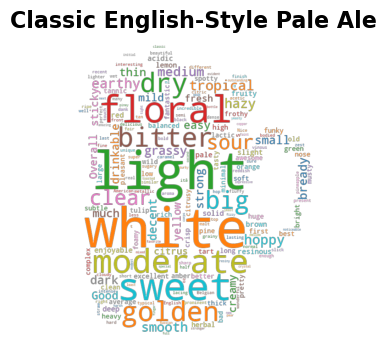

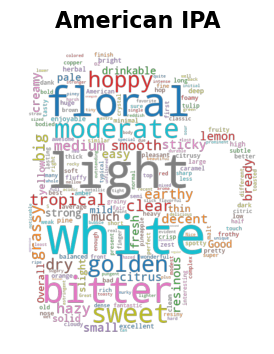

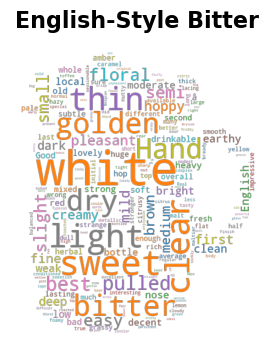

['Classic English-Style Pale Ale', 'American IPA', 'English-Style Bitter']

In [18]:
recommendation("region", "style", "Europe")

Top 3 popular beer_names with rich: ['Trappistes Rochefort 10', 'AleSmith Speedway Stout', 'Brooklyn Black Chocolate Stout']


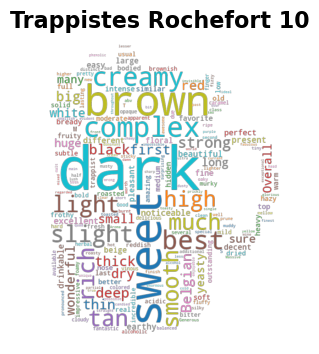

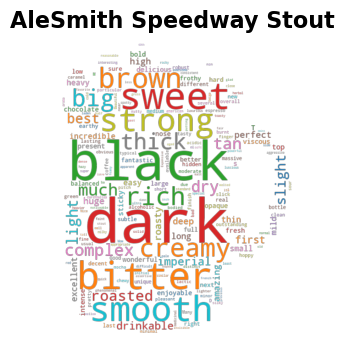

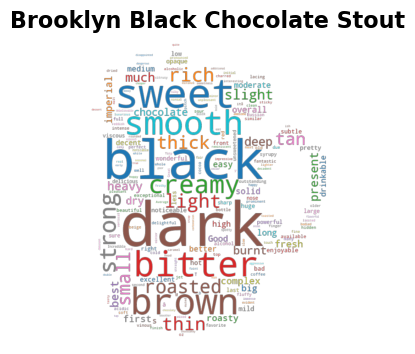

['Trappistes Rochefort 10',
 'AleSmith Speedway Stout',
 'Brooklyn Black Chocolate Stout']

In [32]:
recommendation("keyword", "beer_name", "rich")

Similar styles with Stout: ['Imperial Porter', 'American Porter', 'Dry Stout', 'Irish Dry Stout', 'Sweet Stout', 'Milk / Sweet Stout', 'Schwarzbier', 'American Double / Imperial Pilsner', 'Vienna Lager', 'English Brown Ale']


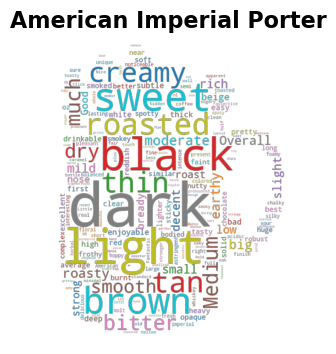

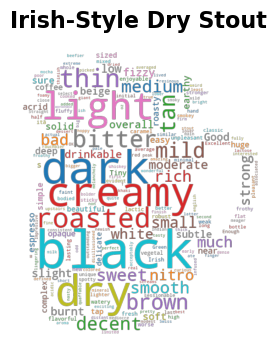

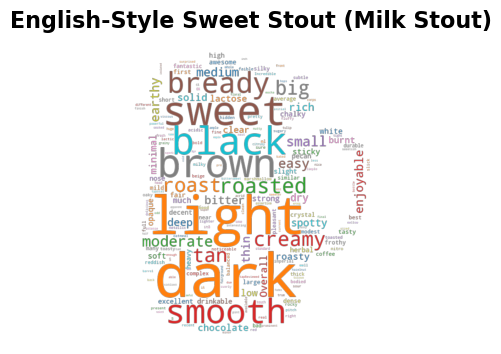

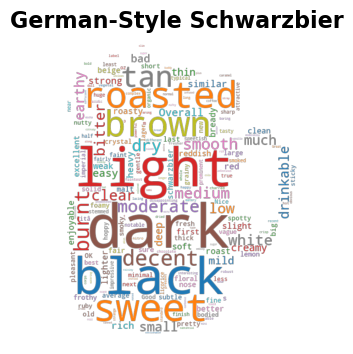

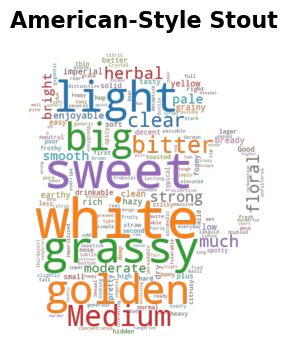

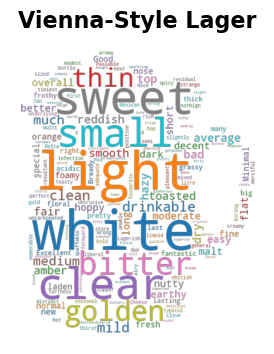

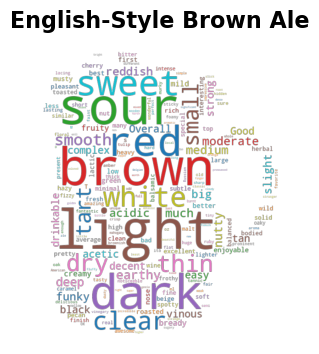

['Imperial Porter',
 'American Porter',
 'Dry Stout',
 'Irish Dry Stout',
 'Sweet Stout',
 'Milk / Sweet Stout']

In [36]:
recommendation("similarity", "style", "Stout")